<a href="https://colab.research.google.com/gist/memetsumer/00ac40ebe2f7aca1ae3c8cfd2ab583ae/face-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Assure using tf version 2.x 
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model, Input
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os

In [2]:
# Confirms using GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [ ]:
# Select API-key file 
from google.colab import files
files.upload()

In [ ]:
# Get Kaggle API
!pip install -q kaggle

# Paste key file to .kaggle directory and restrict permissions to key
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Get the dataset
!kaggle datasets download -d jessicali9530/celeba-dataset 

# Create a directory for unzipped dataset
!mkdir unzipped-dataset

# Unzip files
!unzip celeba-dataset.zip -d unzipped-dataset

# Create a directory for generated images
!mkdir generated_images

In [8]:
directory = 'unzipped-dataset/img_align_celeba'

# Get images into tf.data.Dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=directory, color_mode='rgb', batch_size=128,
    image_size=(32, 32), label_mode=None,
    shuffle=True, seed=42)

# Normalize the dataset
dataset = dataset.map(lambda x: x / 255.)

Found 202599 files belonging to 1 classes.


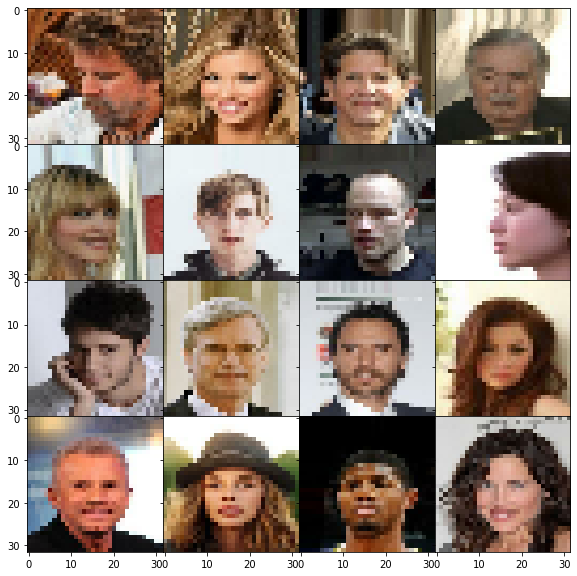

In [9]:
# Get a sample batch
it = iter(dataset)
one_batch = next(it).numpy()
images = one_batch[:16, :, :, :]

# Show some images with ImageGrid
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(4, 4),
                 axes_pad=0,
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()

In [10]:
def generator_model(z_dim=100):

  gen_inputs = Input(shape=(z_dim,), name='generator_input')

  x = layers.Dense(8 * 8 * 3)(gen_inputs)
  x = layers.Reshape(target_shape=(8, 8, 3))(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=512, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(1, 1), padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), padding='same')(x)
  images = layers.LeakyReLU()(x)

  model = Model(inputs=gen_inputs, outputs=images)
  return model

In [13]:
def discriminator_model():
  disc_inputs = Input(shape=(32, 32, 3), name='discriminator_input')
  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(disc_inputs)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=128, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)

  x = layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), padding='same')(x)
  x = layers.LeakyReLU()(x)
  x = layers.Dropout(0.2)(x)
  
  x = layers.Flatten()(x)
  x = layers.Dense(1)(x)
  output = layers.Activation('sigmoid')(x)

  disc = Model(inputs=disc_inputs, outputs=output)
  return disc 

In [14]:
gen_model = generator_model()
disc_model = discriminator_model()

# Compile the model that trains discriminator
disc_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Compile the model that trains generator
z_dim = 100

disc_model.trainable = False
model_input = Input(shape=(z_dim,), name='model_input')
model_output = disc_model(gen_model(model_input))

model = Model(model_input, model_output)

model.compile(    
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

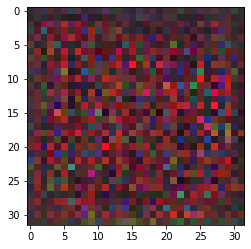

In [15]:
# Let's see how random noise looks
noise1 = np.random.normal(0, 1, (1, 100))
image = gen_model(noise1)
image = tf.keras.preprocessing.image.array_to_img(image[0].numpy())
path = '/content/generated_images'
tf.keras.preprocessing.image.save_img(f'{path}/deneme.jpg', image)
plt.imshow(image)
plt.show()

In [16]:
def train_discriminator(batch, batch_size):
  valid = np.ones((batch_size, 1))
  fake = np.zeros((batch_size ,1))

  # Train on real images
  disc_model.train_on_batch(batch, valid)

  # Train on generated images
  noise = np.random.normal(0, 1, (batch_size, z_dim))
  gen_imgs = gen_model.predict(noise)
  disc_model.train_on_batch(gen_imgs, fake)

def train_generator(batch_size):
  valid = np.ones((batch_size, 1))
  noise = np.random.normal(0, 1, (batch_size, z_dim))
  model.train_on_batch(noise, valid)

In [17]:
def save_image(fake_image, path):
  image = tf.keras.preprocessing.image.array_to_img(fake_image.numpy())
  tf.keras.preprocessing.image.save_img(path, image)
  return image

def generate_and_save_image(path):
  noise = np.random.normal(0, 1, (1, z_dim))
  fake_image = gen_model(noise)
  image = save_image(fake_image[0], path)
  plt.imshow(image)
  plt.show()

epoch no. 0
batch no. 0


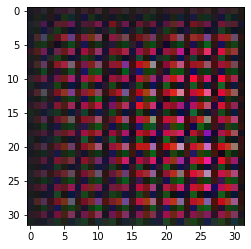

batch no. 200


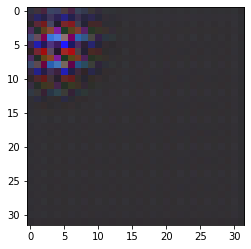

batch no. 400


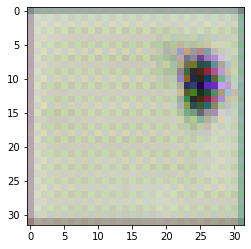

batch no. 600


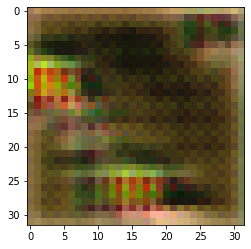

batch no. 800


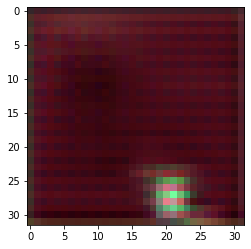

batch no. 1000


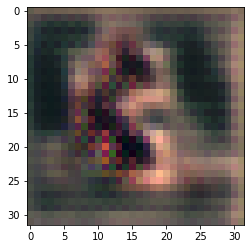

batch no. 1200


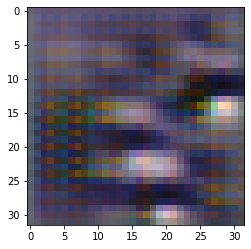

batch no. 1400


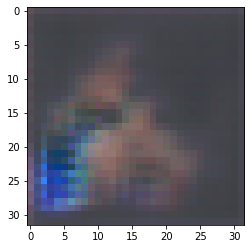

epoch no. 1
batch no. 0


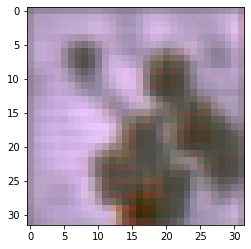

batch no. 200


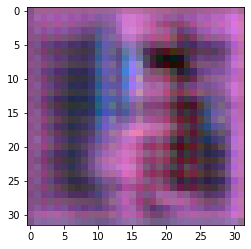

batch no. 400


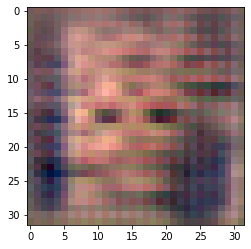

batch no. 600


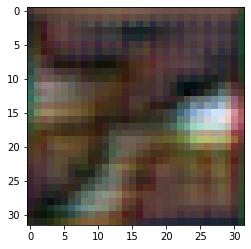

batch no. 800


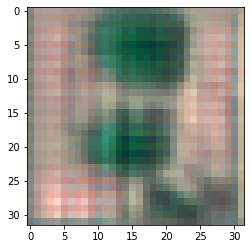

batch no. 1000


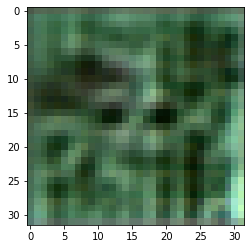

batch no. 1200


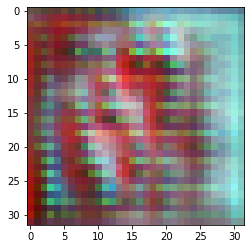

batch no. 1400


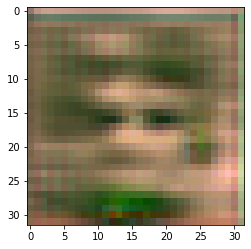

epoch no. 2
batch no. 0


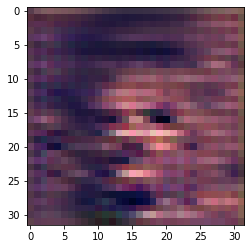

batch no. 200


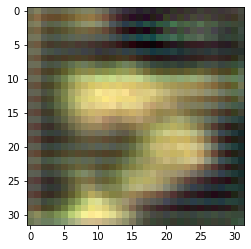

batch no. 400


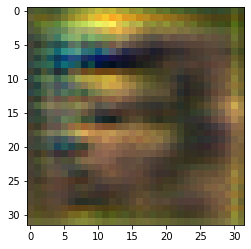

batch no. 600


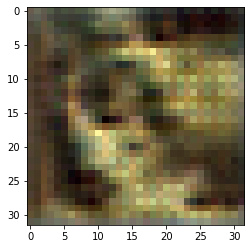

batch no. 800


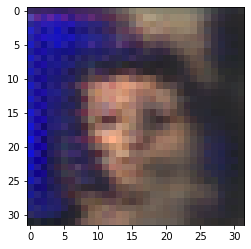

batch no. 1000


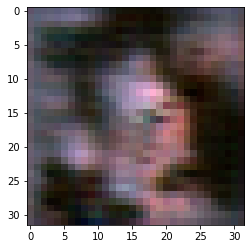

batch no. 1200


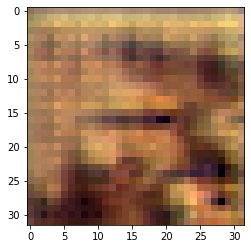

batch no. 1400


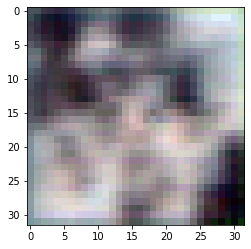

epoch no. 3
batch no. 0


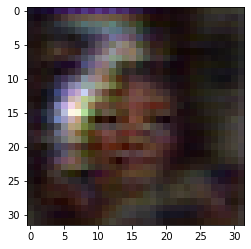

batch no. 200


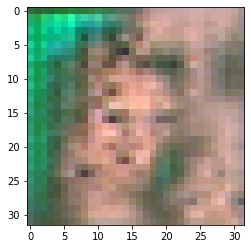

batch no. 400


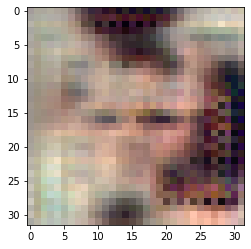

batch no. 600


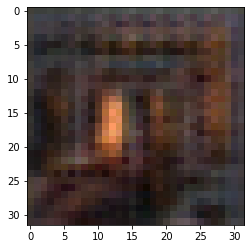

batch no. 800


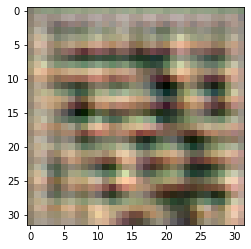

batch no. 1000


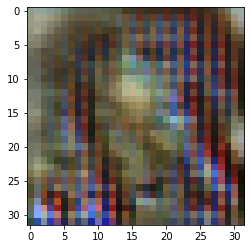

batch no. 1200


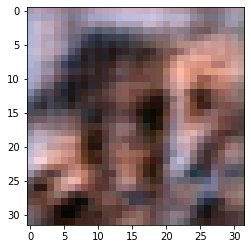

batch no. 1400


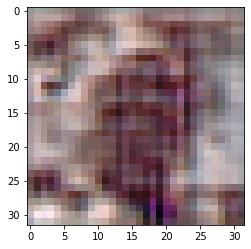

epoch no. 4
batch no. 0


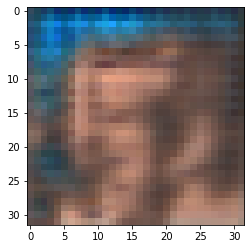

batch no. 200


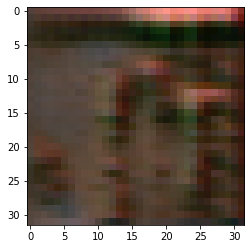

batch no. 400


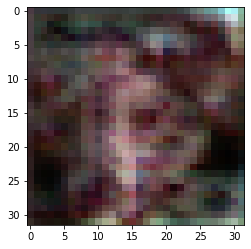

batch no. 600


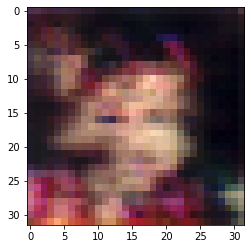

batch no. 800


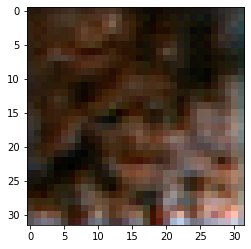

batch no. 1000


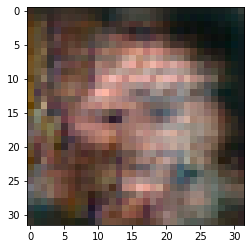

batch no. 1200


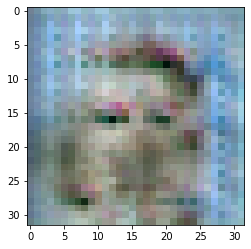

batch no. 1400
batch no. 1400


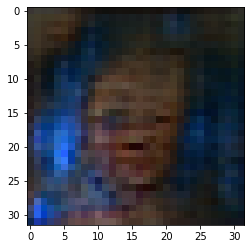

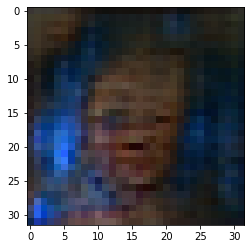

epoch no. 5
epoch no. 5
batch no. 0
batch no. 0


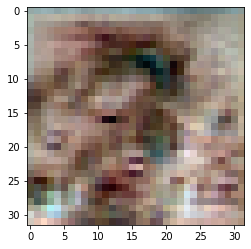

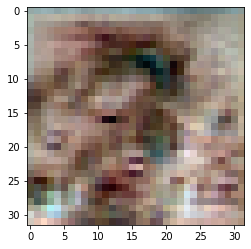

batch no. 200
batch no. 200


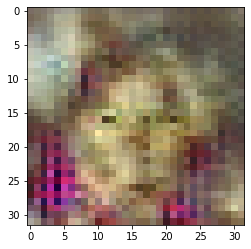

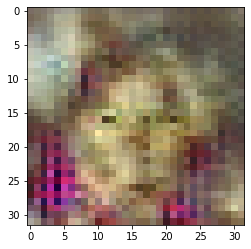

batch no. 400
batch no. 400


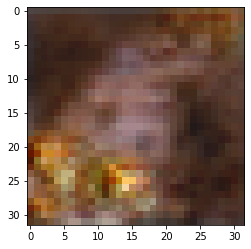

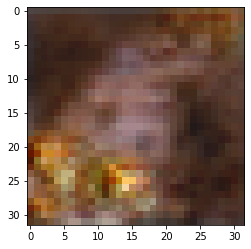

batch no. 600
batch no. 600


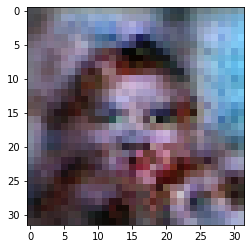

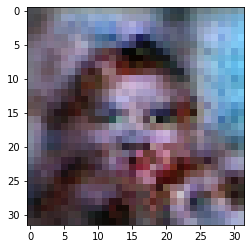

batch no. 800
batch no. 800


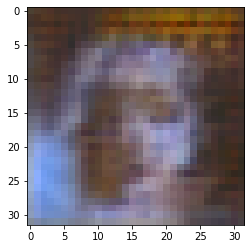

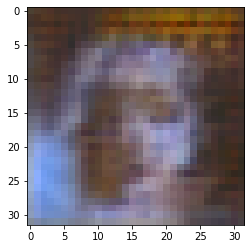

batch no. 1000
batch no. 1000


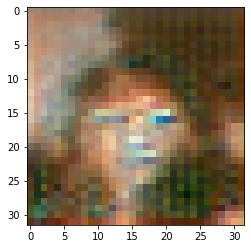

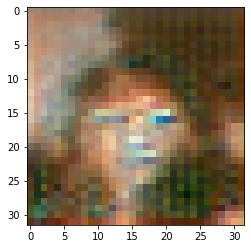

batch no. 1200
batch no. 1200


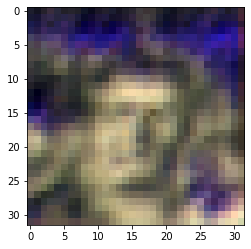

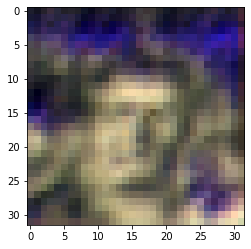

batch no. 1400
batch no. 1400


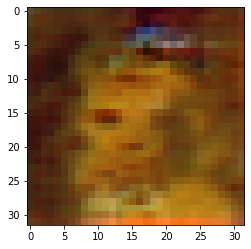

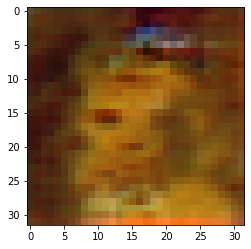

epoch no. 6
epoch no. 6
batch no. 0
batch no. 0


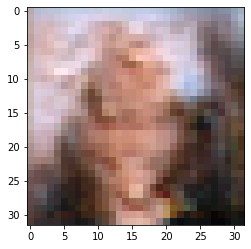

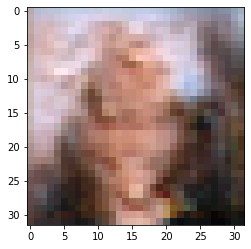

batch no. 200
batch no. 200


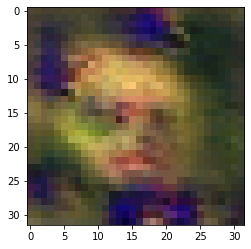

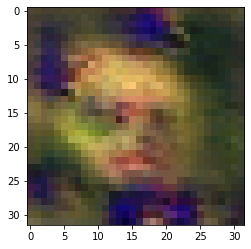

batch no. 400
batch no. 400


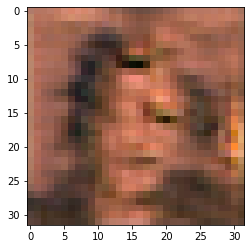

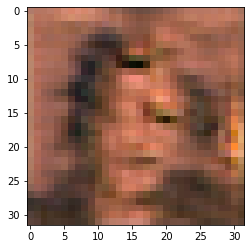

batch no. 600
batch no. 600


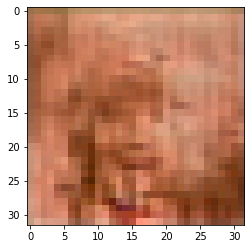

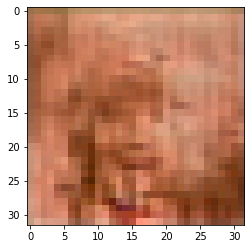

batch no. 800
batch no. 800


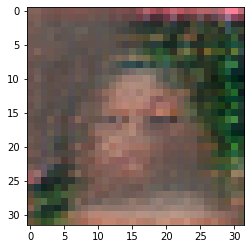

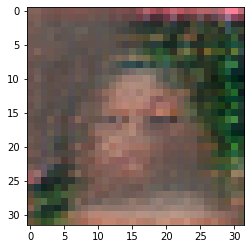

batch no. 1000
batch no. 1000


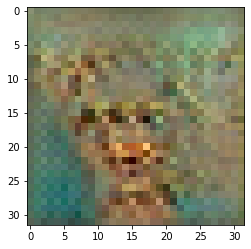

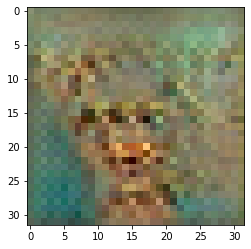

batch no. 1200
batch no. 1200


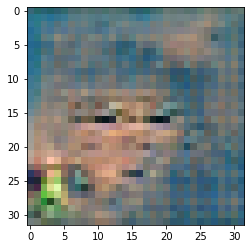

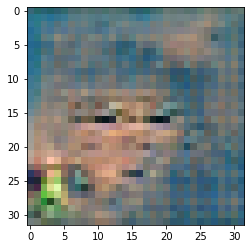

batch no. 1400
batch no. 1400


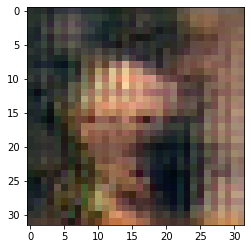

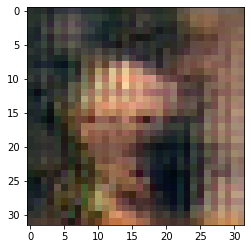

epoch no. 7
epoch no. 7
batch no. 0
batch no. 0


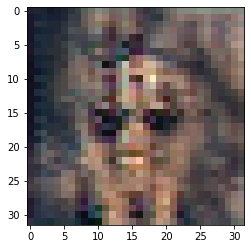

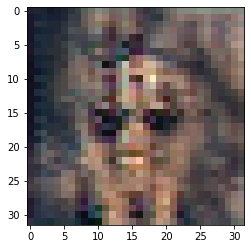

batch no. 200
batch no. 200


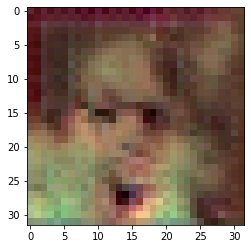

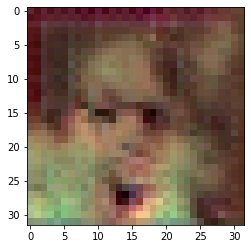

batch no. 400
batch no. 400


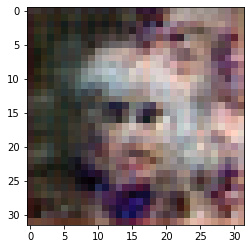

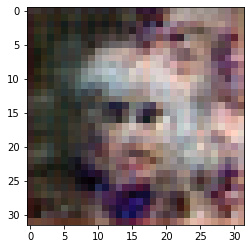

batch no. 600
batch no. 600


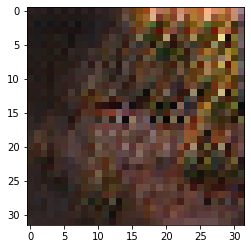

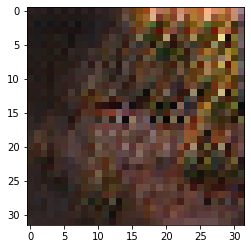

batch no. 800
batch no. 800


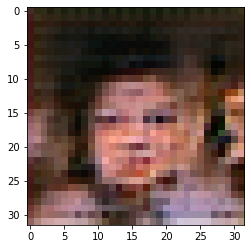

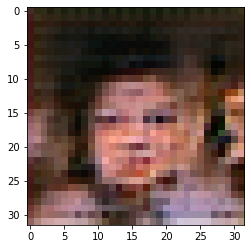

batch no. 1000
batch no. 1000


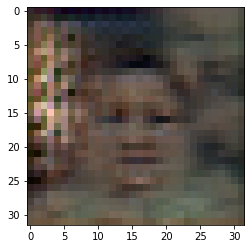

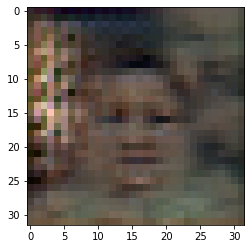

batch no. 1200
batch no. 1200


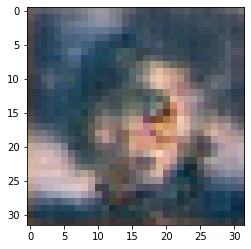

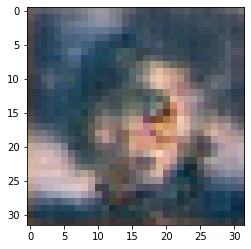

batch no. 1400
batch no. 1400


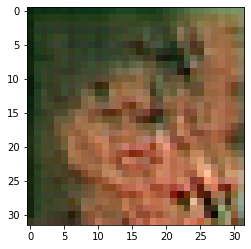

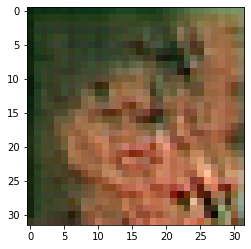

epoch no. 8
epoch no. 8
batch no. 0
batch no. 0


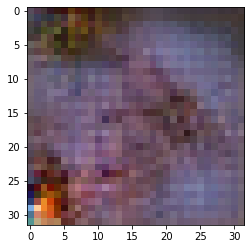

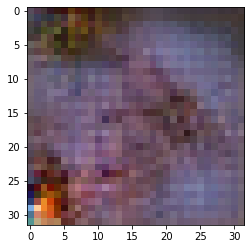

batch no. 200
batch no. 200


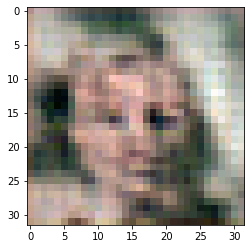

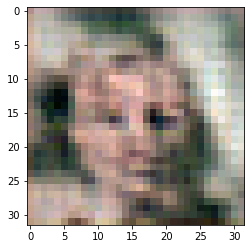

batch no. 400
batch no. 400


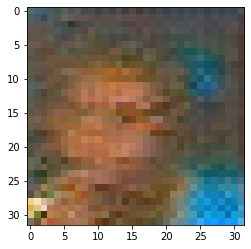

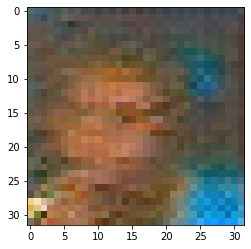

batch no. 600
batch no. 600


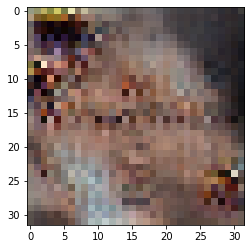

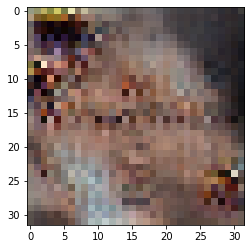

batch no. 800
batch no. 800


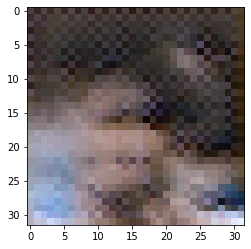

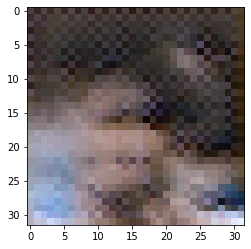

batch no. 1000
batch no. 1000


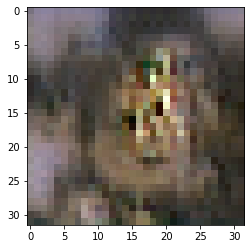

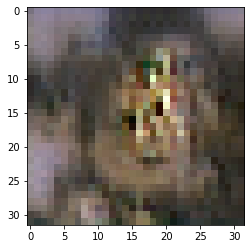

batch no. 1200
batch no. 1200


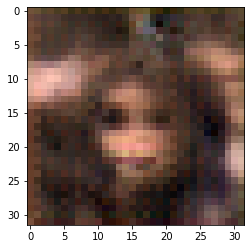

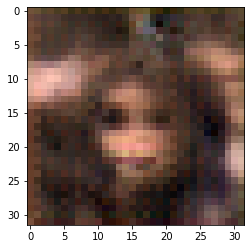

batch no. 1400
batch no. 1400


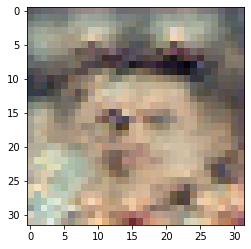

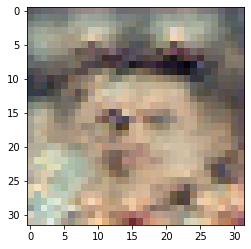

epoch no. 9
epoch no. 9
batch no. 0
batch no. 0


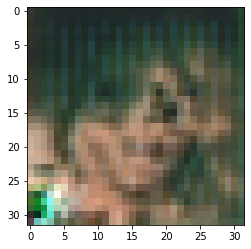

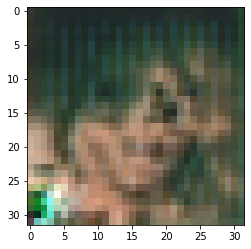

batch no. 200
batch no. 200


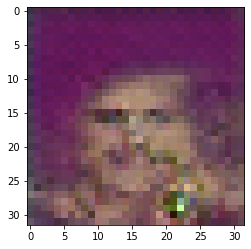

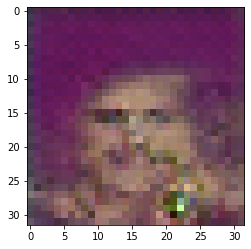

batch no. 400
batch no. 400


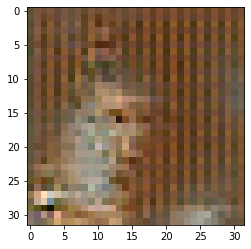

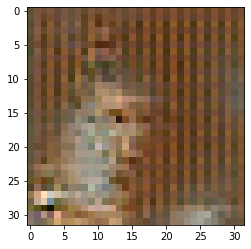

batch no. 600
batch no. 600


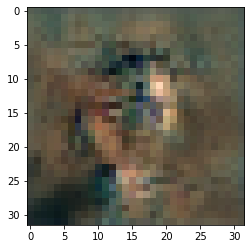

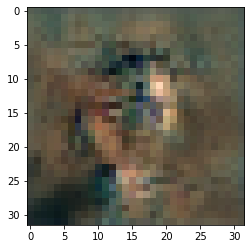

batch no. 800
batch no. 800


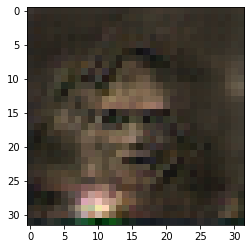

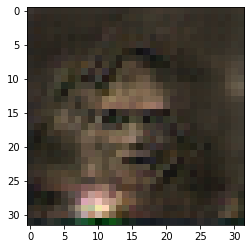

batch no. 1000
batch no. 1000


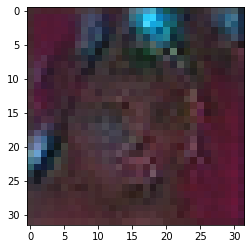

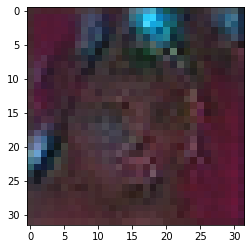

batch no. 1200
batch no. 1200


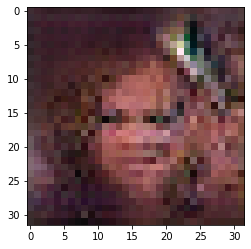

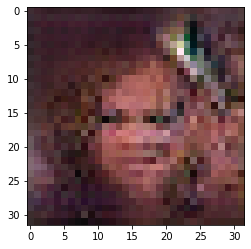

batch no. 1400
batch no. 1400


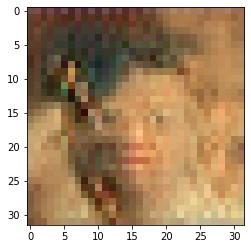

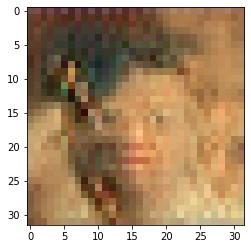

epoch no. 10
epoch no. 10
batch no. 0
batch no. 0


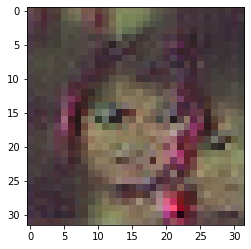

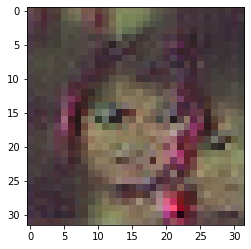

batch no. 200
batch no. 200


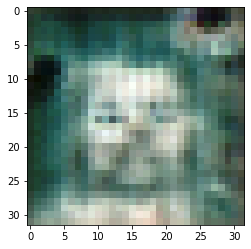

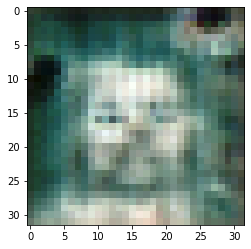

batch no. 400
batch no. 400


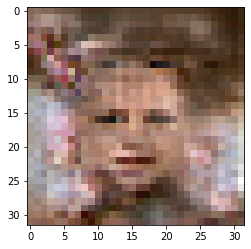

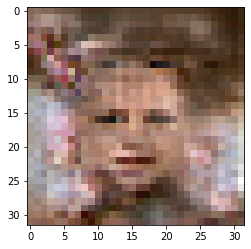

batch no. 600
batch no. 600


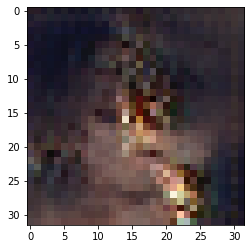

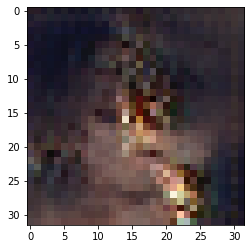

batch no. 800
batch no. 800


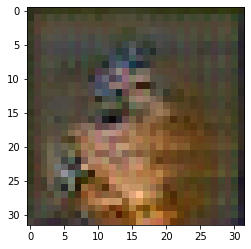

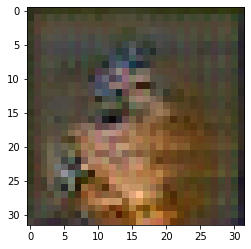

batch no. 1000
batch no. 1000


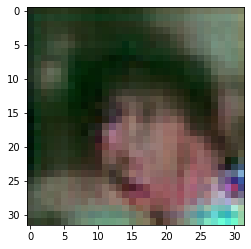

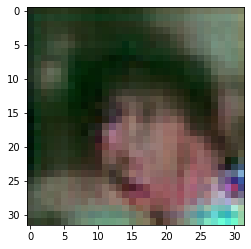

batch no. 1200
batch no. 1200


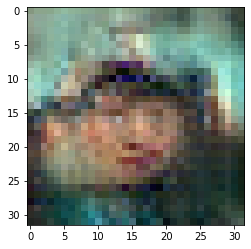

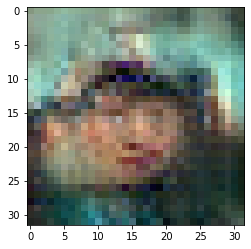

batch no. 1400
batch no. 1400


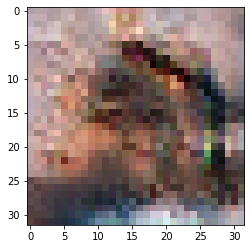

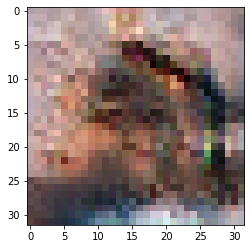

epoch no. 11
epoch no. 11
batch no. 0
batch no. 0


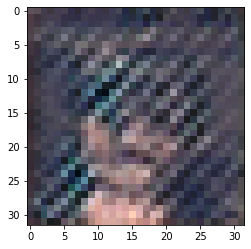

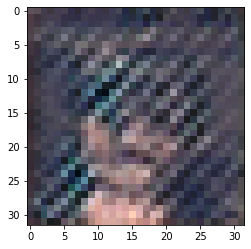

batch no. 200
batch no. 200


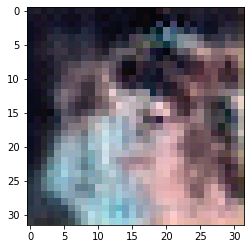

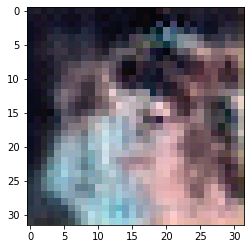

batch no. 400
batch no. 400


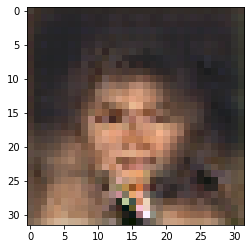

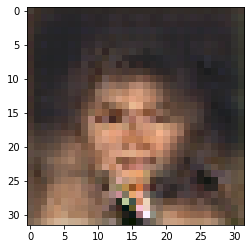

batch no. 600
batch no. 600


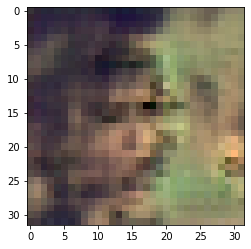

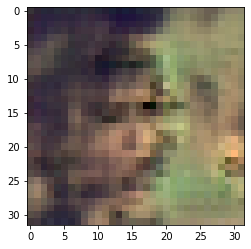

batch no. 800
batch no. 800


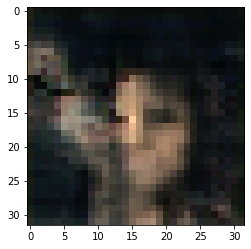

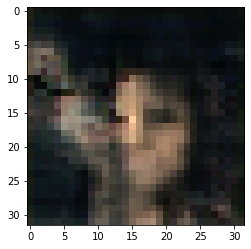

batch no. 1000
batch no. 1000


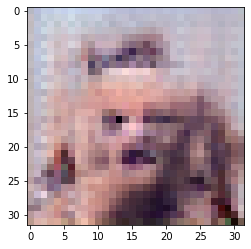

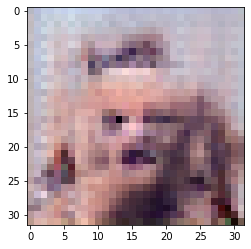

batch no. 1200
batch no. 1200


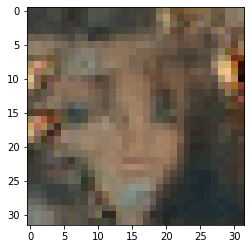

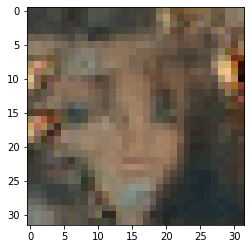

batch no. 1400
batch no. 1400


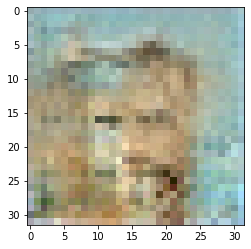

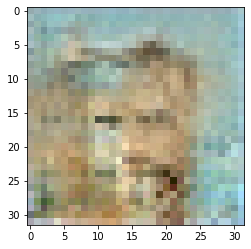

epoch no. 12
epoch no. 12
batch no. 0
batch no. 0


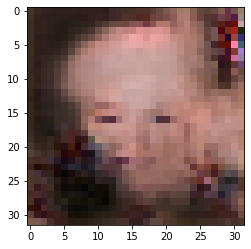

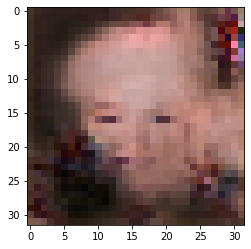

batch no. 200
batch no. 200


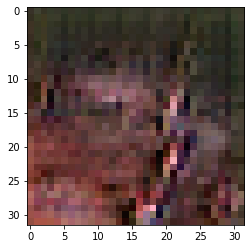

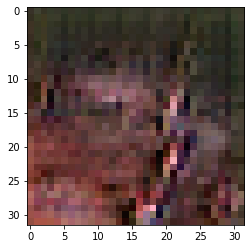

batch no. 400
batch no. 400


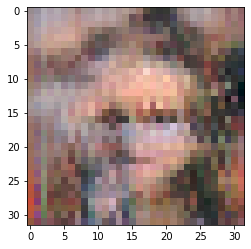

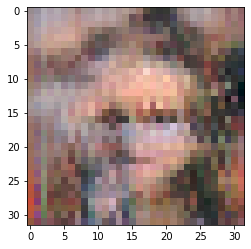

batch no. 600
batch no. 600


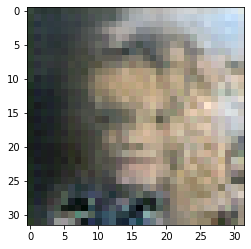

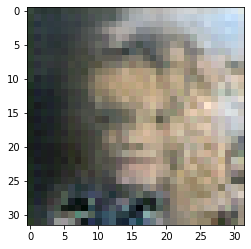

batch no. 800
batch no. 800


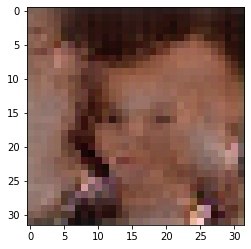

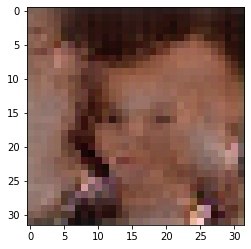

batch no. 1000
batch no. 1000


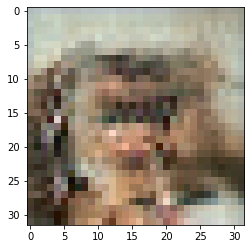

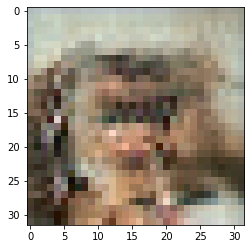

batch no. 1200
batch no. 1200


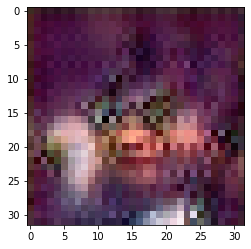

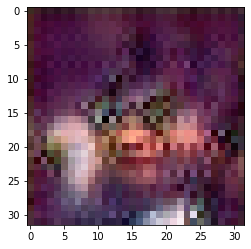

batch no. 1400
batch no. 1400


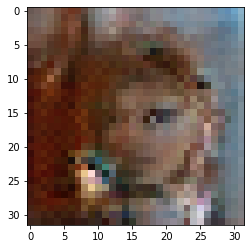

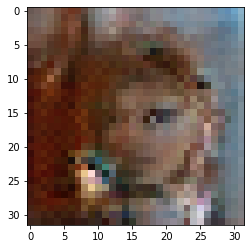

epoch no. 13
epoch no. 13
batch no. 0
batch no. 0


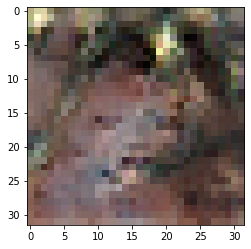

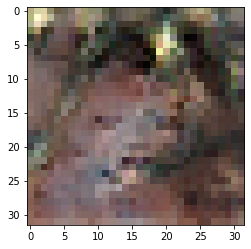

batch no. 200
batch no. 200


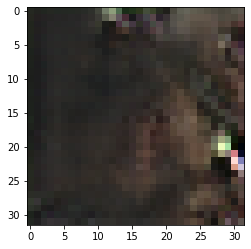

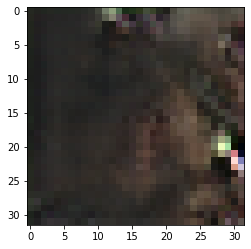

batch no. 400
batch no. 400


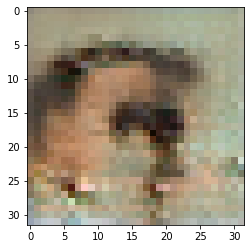

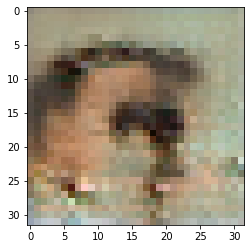

batch no. 600
batch no. 600


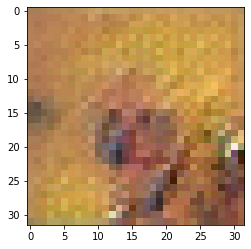

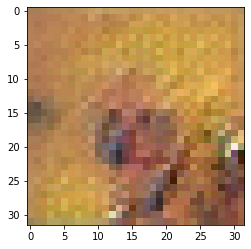

batch no. 800
batch no. 800


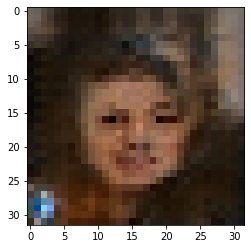

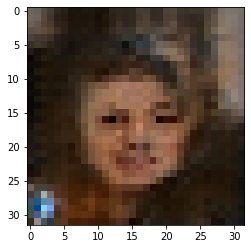

batch no. 1000
batch no. 1000


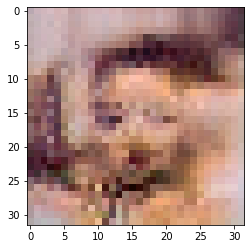

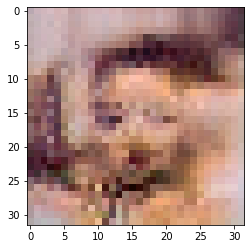

batch no. 1200
batch no. 1200


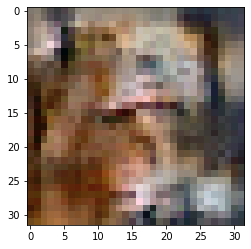

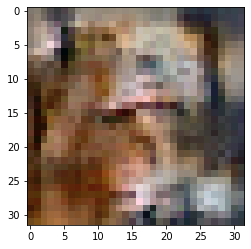

batch no. 1400
batch no. 1400


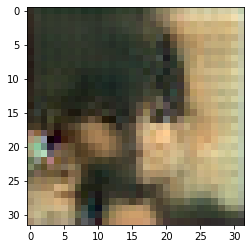

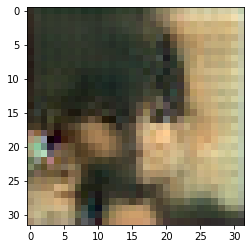

epoch no. 14
epoch no. 14
batch no. 0
batch no. 0


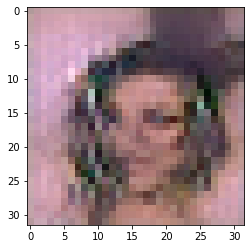

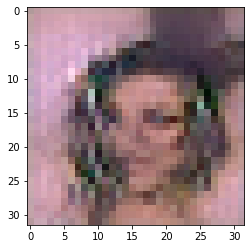

batch no. 200
batch no. 200


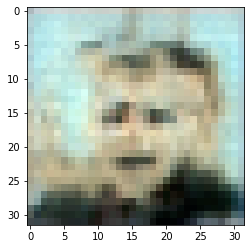

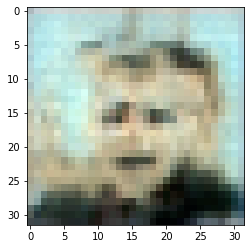

batch no. 400
batch no. 400


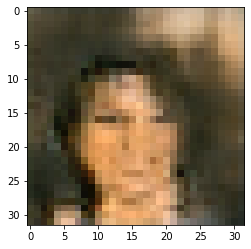

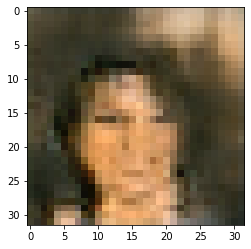

batch no. 600
batch no. 600


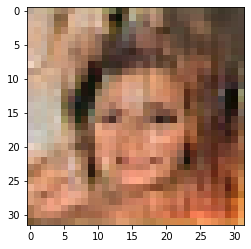

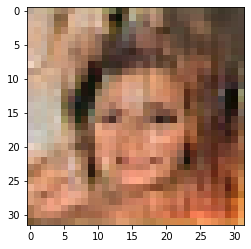

batch no. 800
batch no. 800


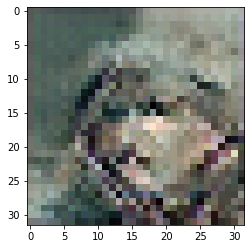

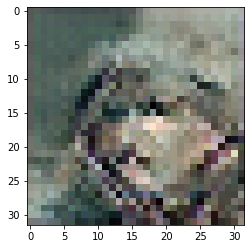

batch no. 1000
batch no. 1000


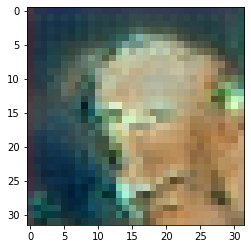

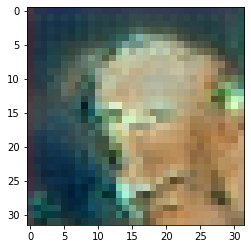

batch no. 1200
batch no. 1200


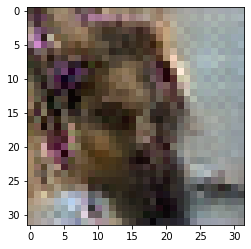

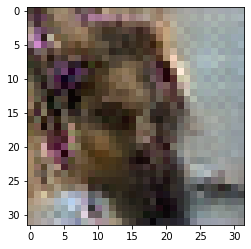

batch no. 1400
batch no. 1400


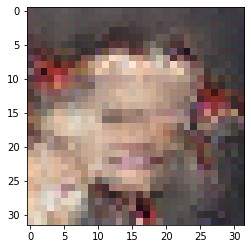

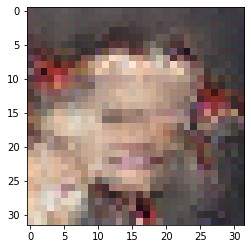

epoch no. 15
epoch no. 15
batch no. 0
batch no. 0


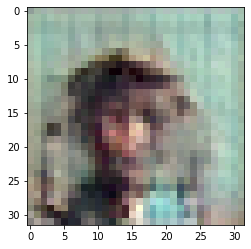

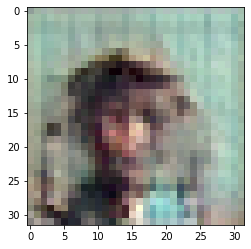

batch no. 200
batch no. 200


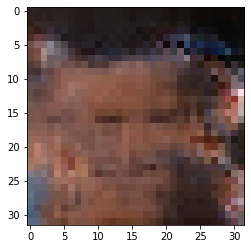

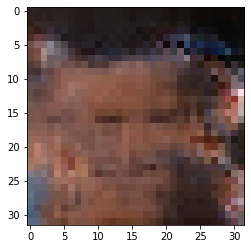

batch no. 400
batch no. 400


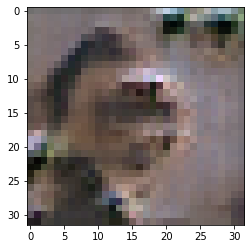

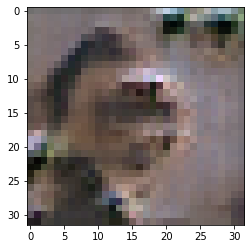

batch no. 600
batch no. 600


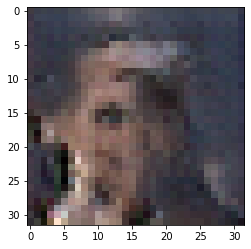

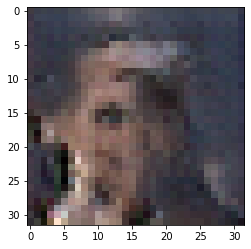

batch no. 800
batch no. 800


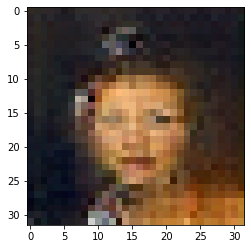

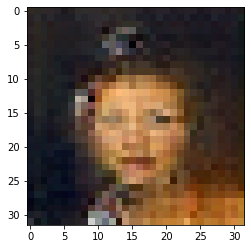

batch no. 1000
batch no. 1000


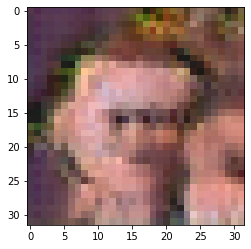

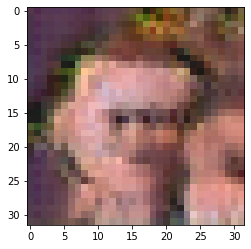

batch no. 1200
batch no. 1200


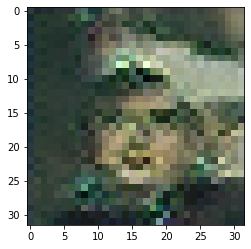

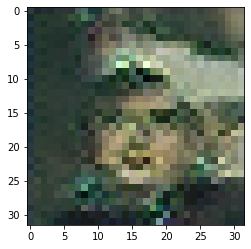

batch no. 1400
batch no. 1400


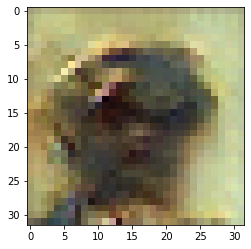

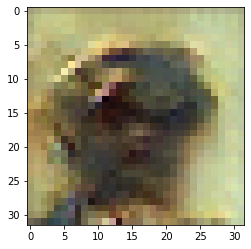

epoch no. 16
epoch no. 16
batch no. 0
batch no. 0


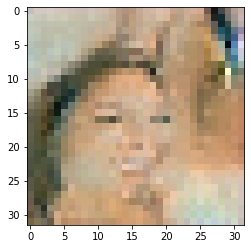

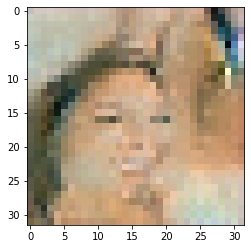

batch no. 200
batch no. 200


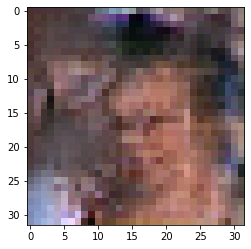

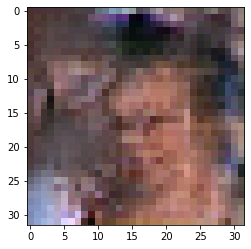

batch no. 400
batch no. 400


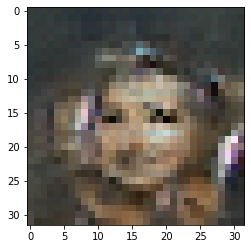

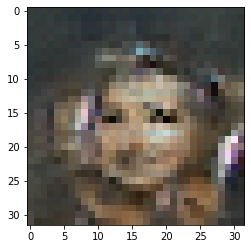

batch no. 600
batch no. 600


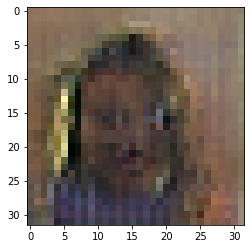

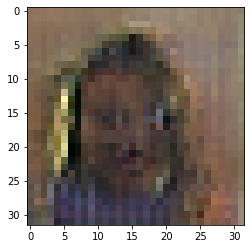

batch no. 800
batch no. 800


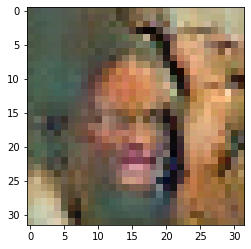

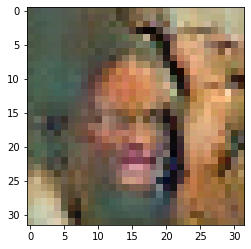

batch no. 1000
batch no. 1000


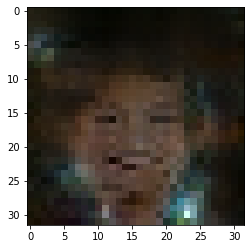

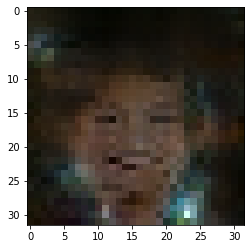

batch no. 1200
batch no. 1200


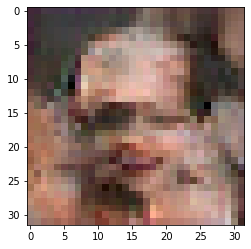

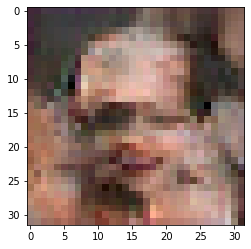

batch no. 1400
batch no. 1400


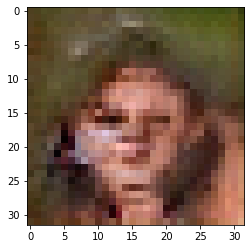

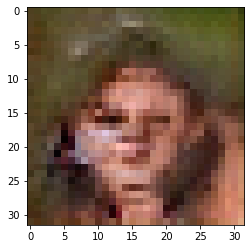

epoch no. 17
epoch no. 17
batch no. 0
batch no. 0


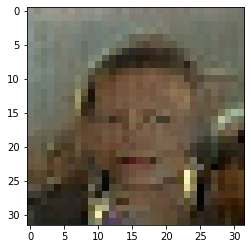

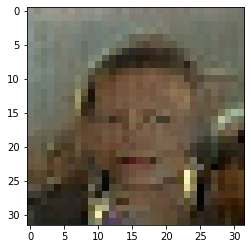

batch no. 200
batch no. 200


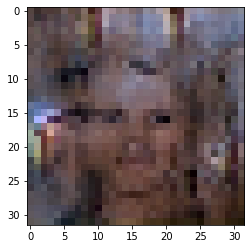

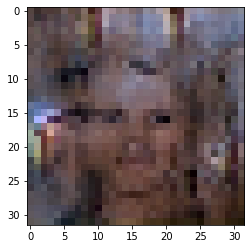

batch no. 400
batch no. 400


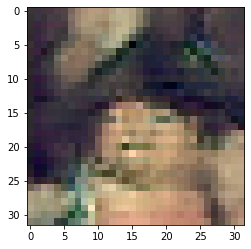

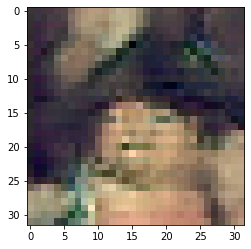

batch no. 600
batch no. 600


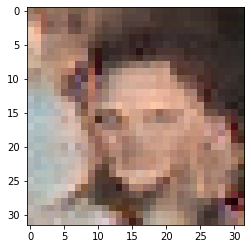

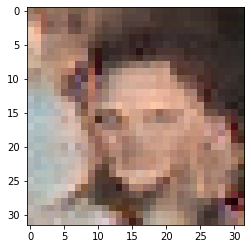

batch no. 800
batch no. 800


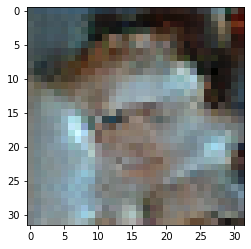

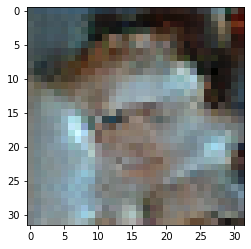

batch no. 1000
batch no. 1000


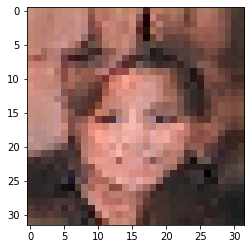

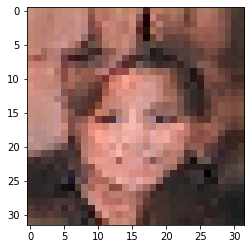

batch no. 1200
batch no. 1200


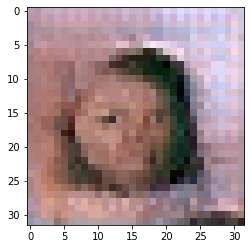

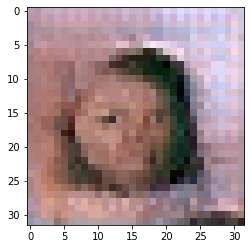

batch no. 1400
batch no. 1400


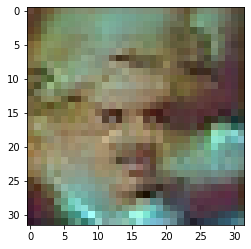

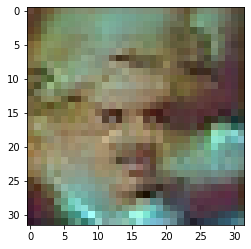

epoch no. 18
epoch no. 18
batch no. 0
batch no. 0


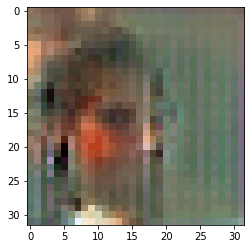

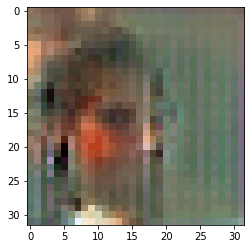

batch no. 200
batch no. 200


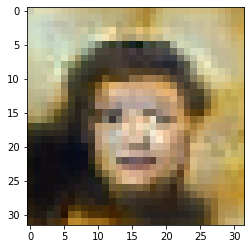

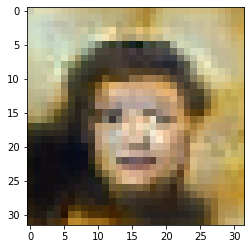

batch no. 400
batch no. 400


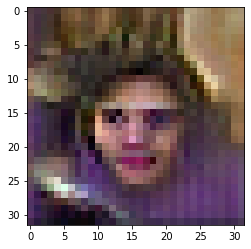

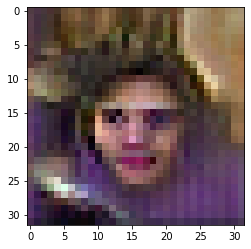

batch no. 600
batch no. 600


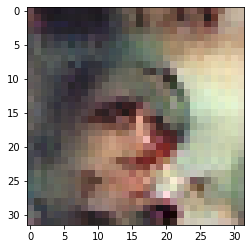

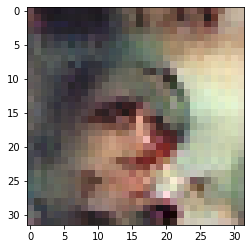

batch no. 800
batch no. 800


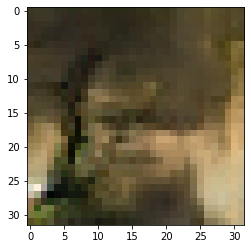

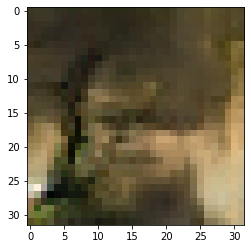

batch no. 1000
batch no. 1000


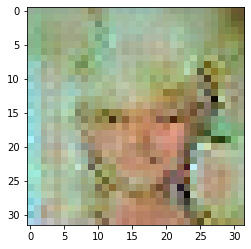

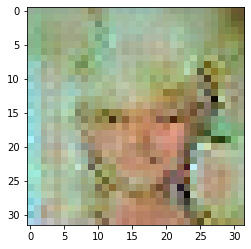

batch no. 1200
batch no. 1200


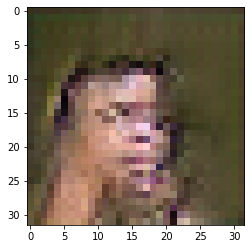

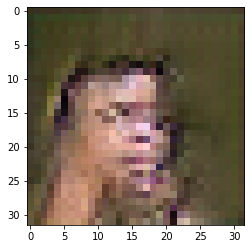

batch no. 1400
batch no. 1400


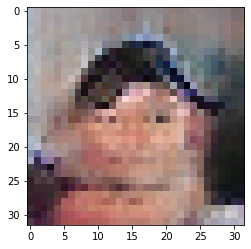

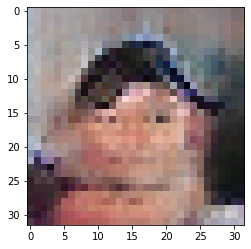

epoch no. 19
epoch no. 19
batch no. 0
batch no. 0


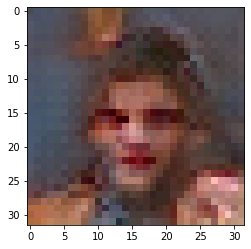

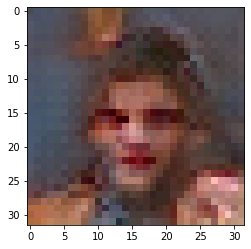

batch no. 200
batch no. 200


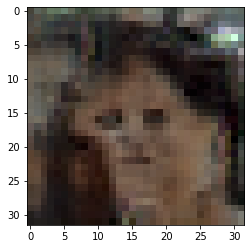

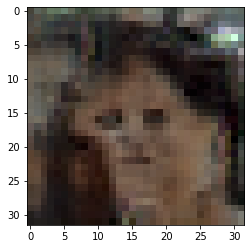

batch no. 400
batch no. 400


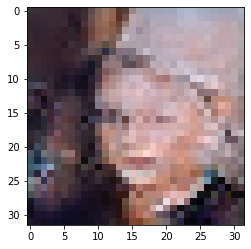

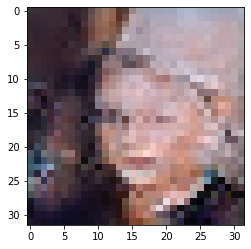

batch no. 600
batch no. 600


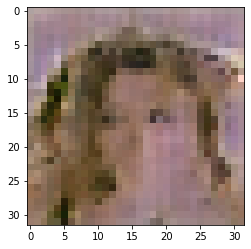

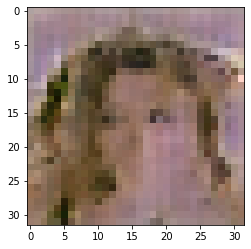

batch no. 800
batch no. 800


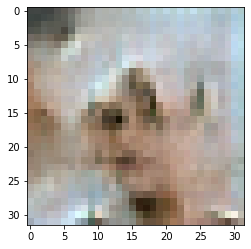

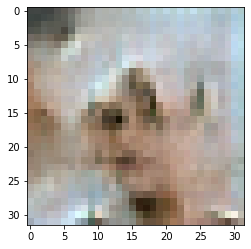

batch no. 1000
batch no. 1000


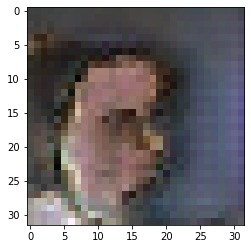

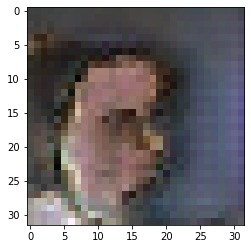

batch no. 1200
batch no. 1200


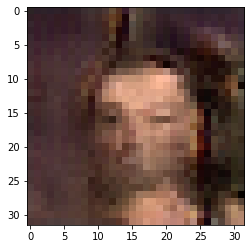

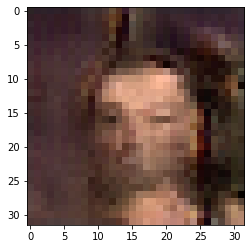

batch no. 1400
batch no. 1400


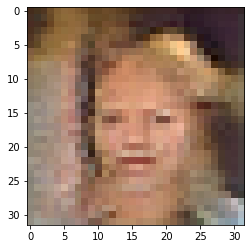

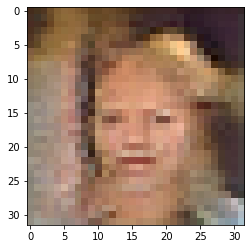

epoch no. 20
epoch no. 20
batch no. 0
batch no. 0


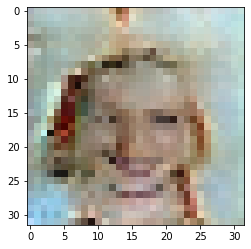

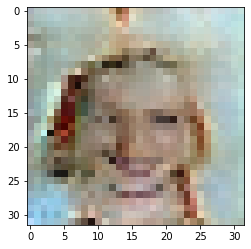

batch no. 200
batch no. 200


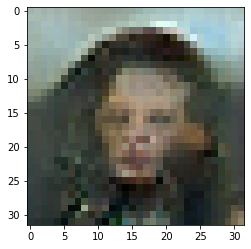

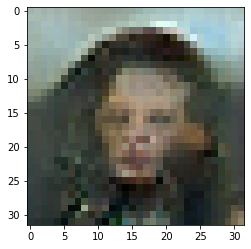

batch no. 400
batch no. 400


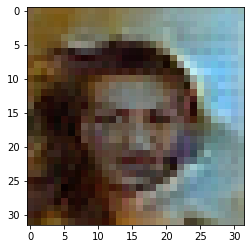

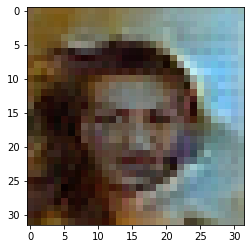

batch no. 600
batch no. 600


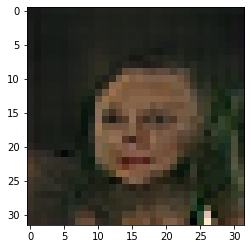

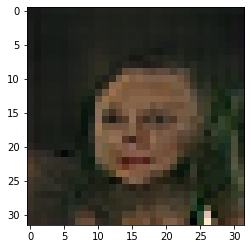

batch no. 800
batch no. 800


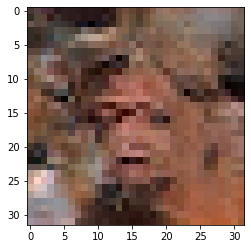

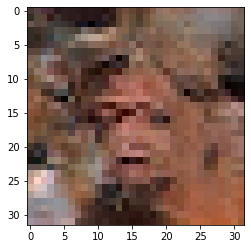

batch no. 1000
batch no. 1000


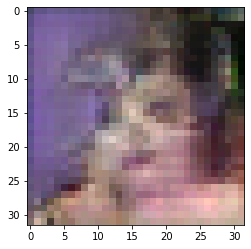

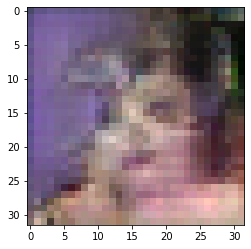

batch no. 1200
batch no. 1200


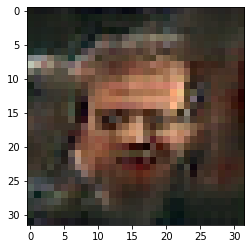

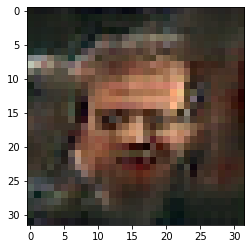

batch no. 1400
batch no. 1400


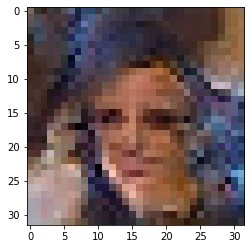

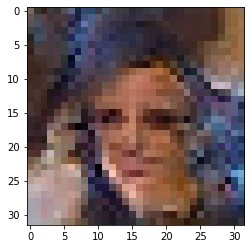

epoch no. 21
epoch no. 21
batch no. 0
batch no. 0


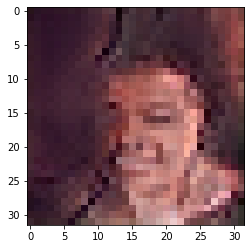

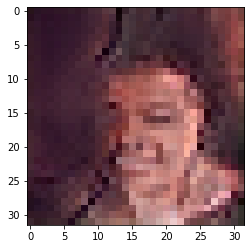

batch no. 200
batch no. 200


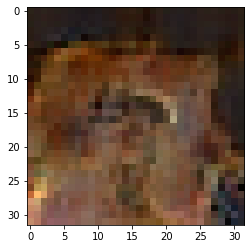

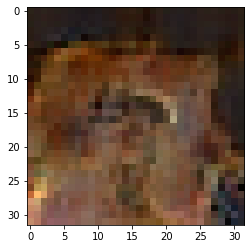

batch no. 400
batch no. 400


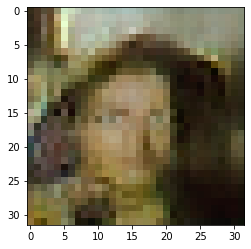

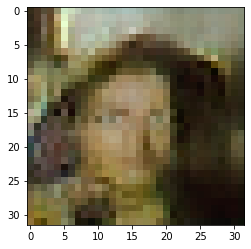

batch no. 600
batch no. 600


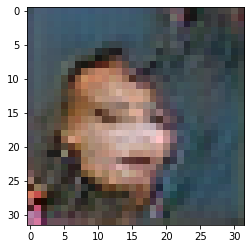

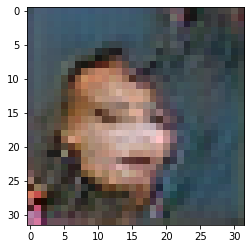

batch no. 800
batch no. 800


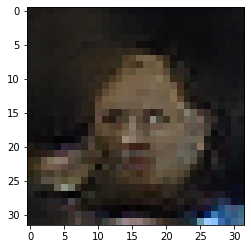

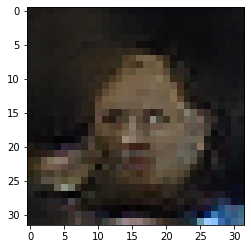

batch no. 1000
batch no. 1000


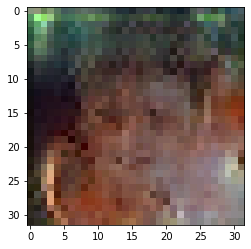

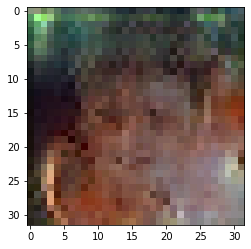

batch no. 1200
batch no. 1200


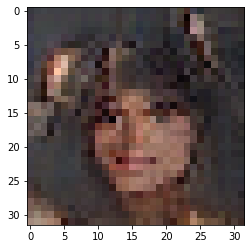

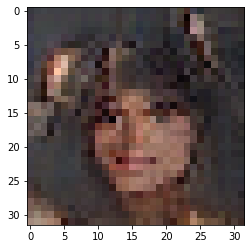

batch no. 1400
batch no. 1400


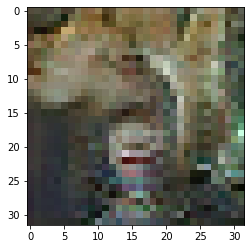

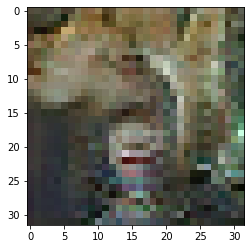

epoch no. 22
epoch no. 22
batch no. 0
batch no. 0


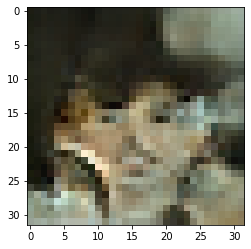

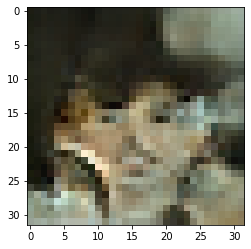

batch no. 200
batch no. 200


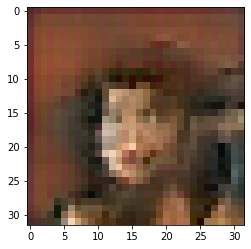

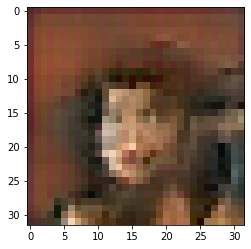

batch no. 400
batch no. 400


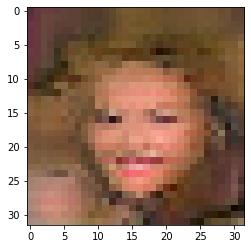

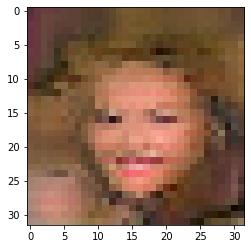

batch no. 600
batch no. 600


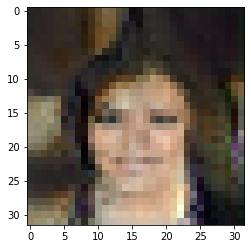

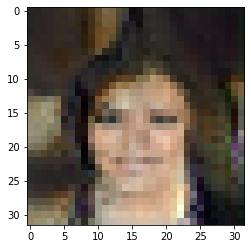

batch no. 800
batch no. 800


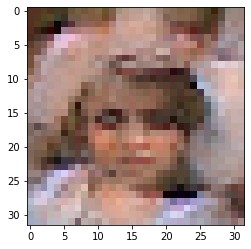

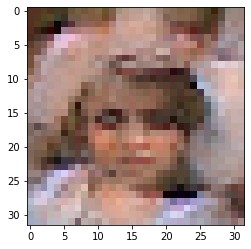

batch no. 1000
batch no. 1000


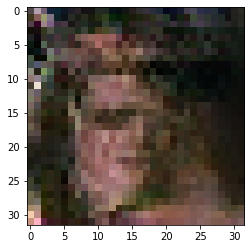

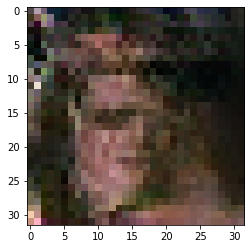

batch no. 1200
batch no. 1200


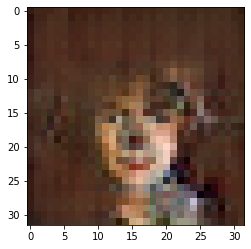

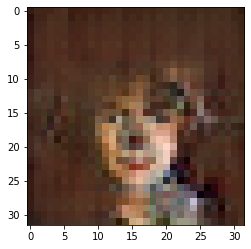

batch no. 1400
batch no. 1400


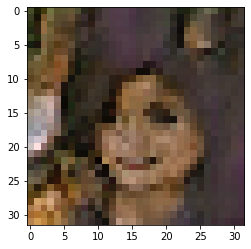

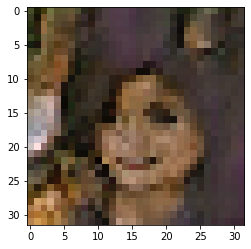

epoch no. 23
epoch no. 23
batch no. 0
batch no. 0


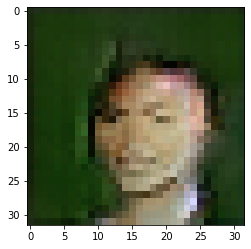

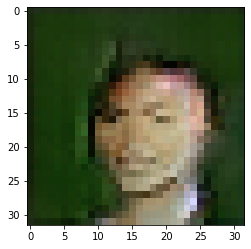

batch no. 200
batch no. 200


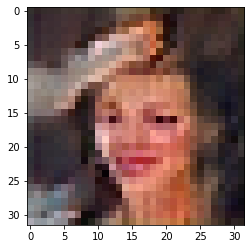

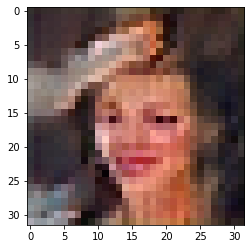

batch no. 400
batch no. 400


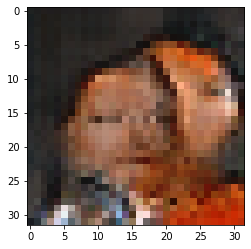

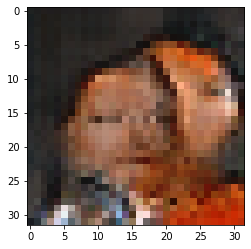

batch no. 600
batch no. 600


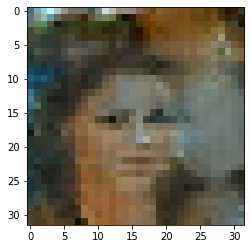

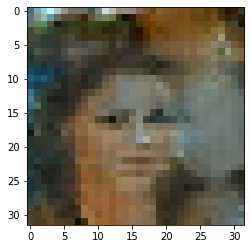

batch no. 800
batch no. 800


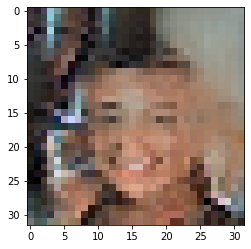

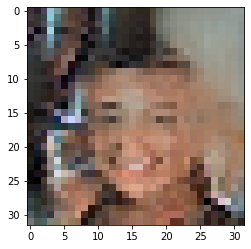

batch no. 1000
batch no. 1000


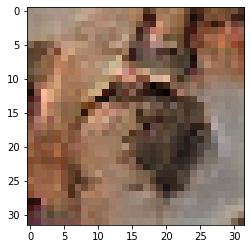

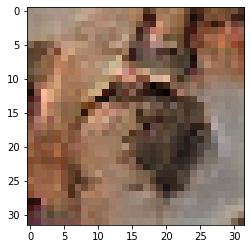

batch no. 1200
batch no. 1200


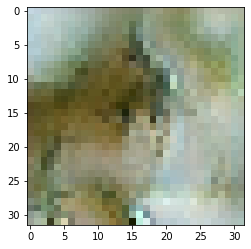

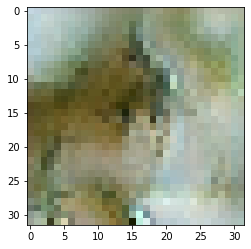

batch no. 1400
batch no. 1400


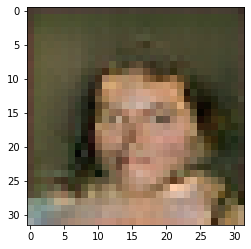

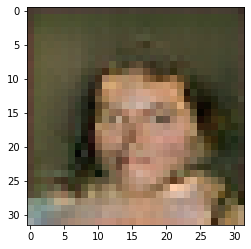

epoch no. 24
epoch no. 24
batch no. 0
batch no. 0


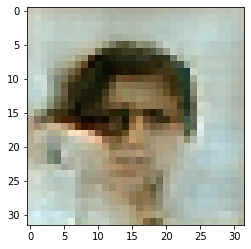

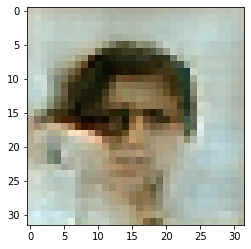

batch no. 200
batch no. 200


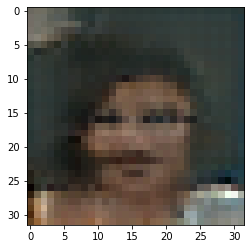

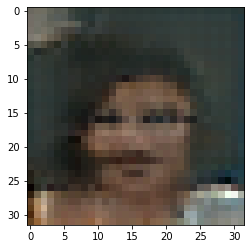

batch no. 400
batch no. 400


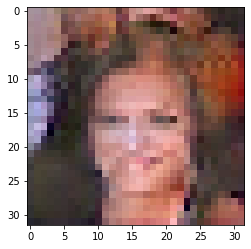

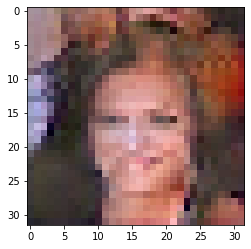

batch no. 600
batch no. 600


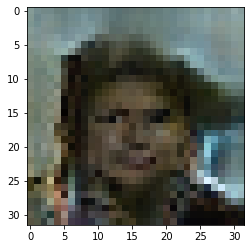

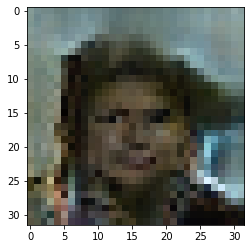

batch no. 800
batch no. 800


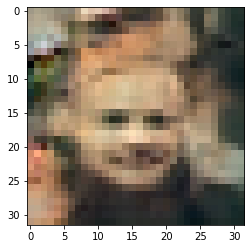

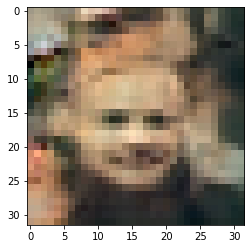

batch no. 1000
batch no. 1000


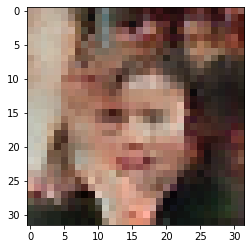

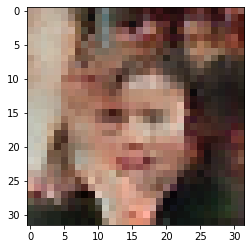

batch no. 1200
batch no. 1200


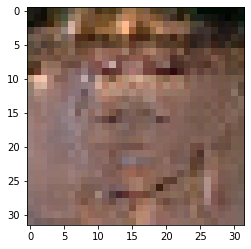

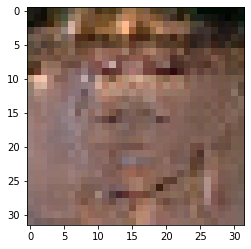

batch no. 1400
batch no. 1400


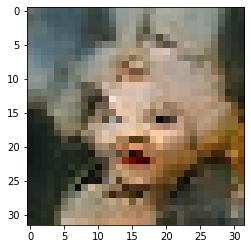

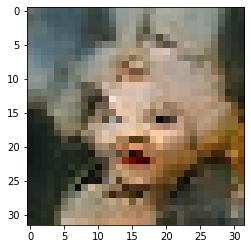

epoch no. 25
epoch no. 25
batch no. 0
batch no. 0


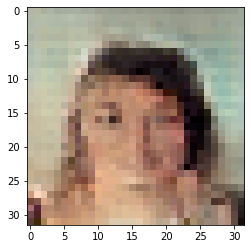

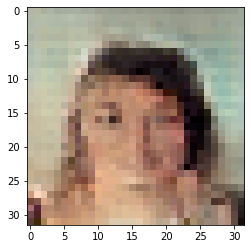

batch no. 200
batch no. 200


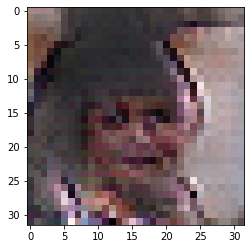

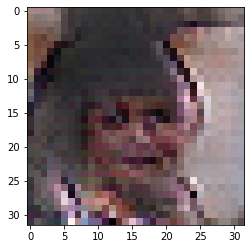

batch no. 400
batch no. 400


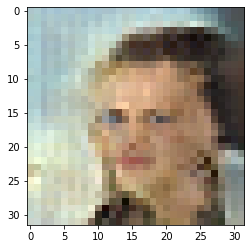

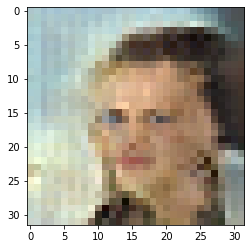

batch no. 600
batch no. 600


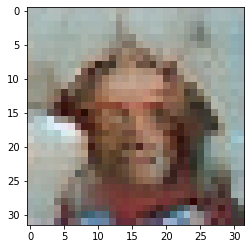

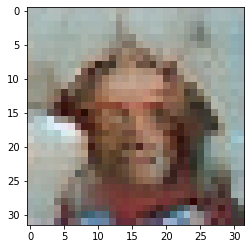

batch no. 800
batch no. 800


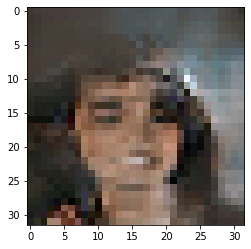

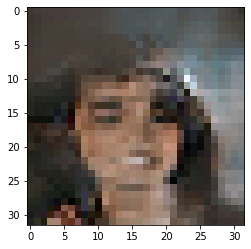

batch no. 1000
batch no. 1000


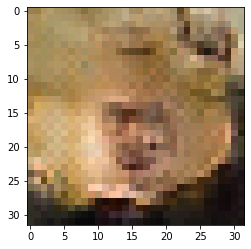

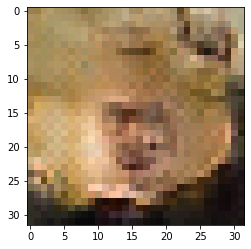

batch no. 1200
batch no. 1200


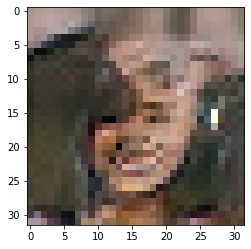

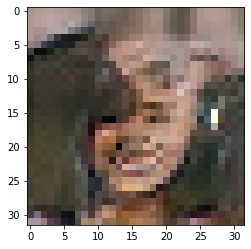

batch no. 1400
batch no. 1400


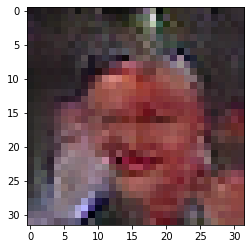

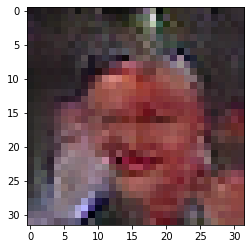

epoch no. 26
epoch no. 26
batch no. 0
batch no. 0


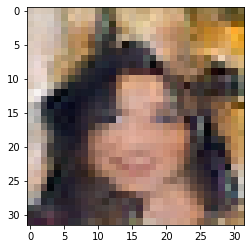

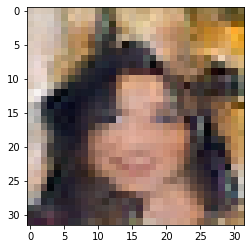

batch no. 200
batch no. 200


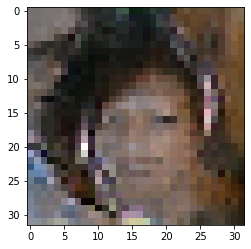

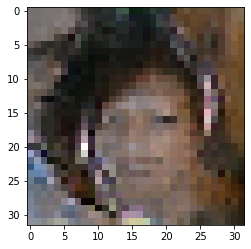

batch no. 400
batch no. 400


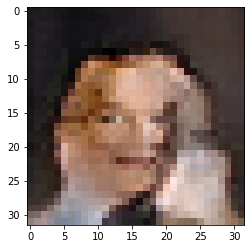

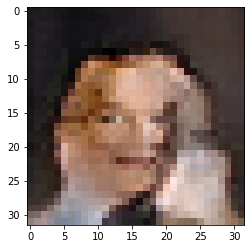

batch no. 600
batch no. 600


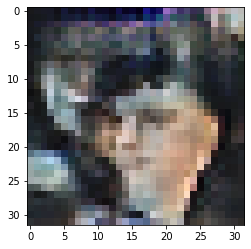

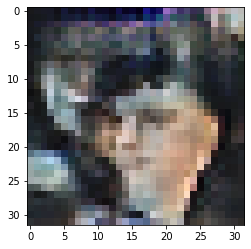

batch no. 800
batch no. 800


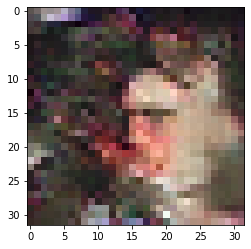

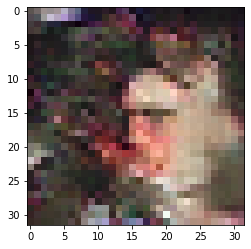

batch no. 1000
batch no. 1000


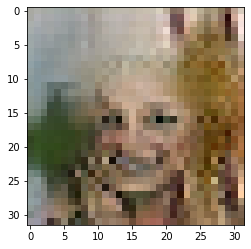

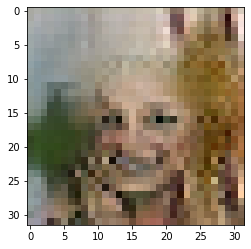

batch no. 1200
batch no. 1200


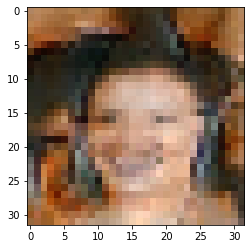

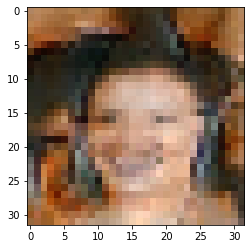

batch no. 1400
batch no. 1400


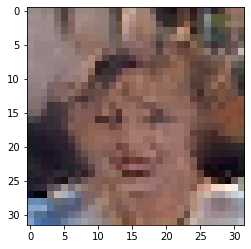

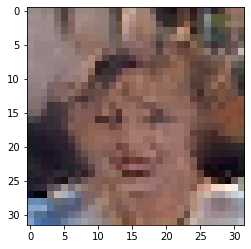

epoch no. 27
epoch no. 27
batch no. 0
batch no. 0


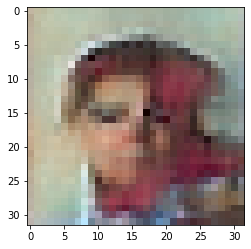

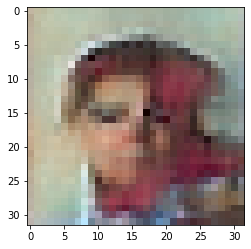

batch no. 200
batch no. 200


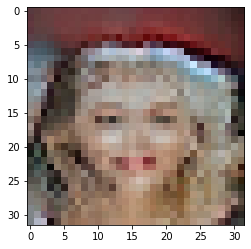

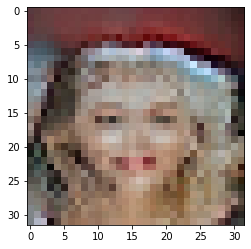

batch no. 400
batch no. 400


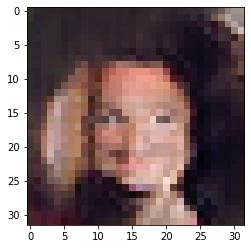

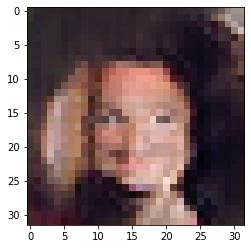

batch no. 600
batch no. 600


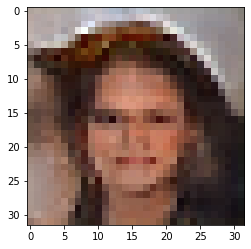

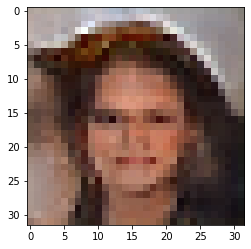

batch no. 800
batch no. 800


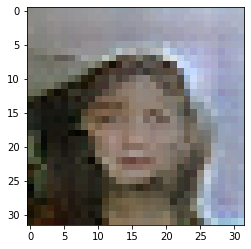

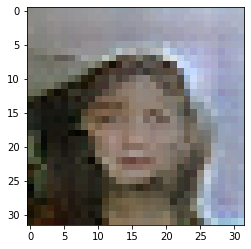

batch no. 1000
batch no. 1000


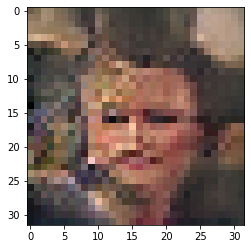

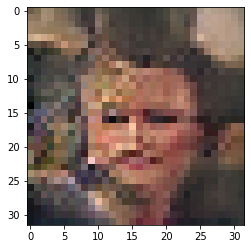

batch no. 1200
batch no. 1200


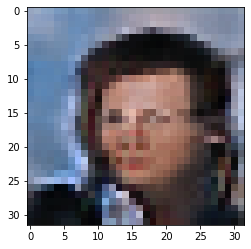

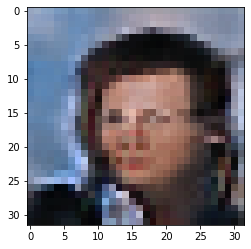

batch no. 1400
batch no. 1400


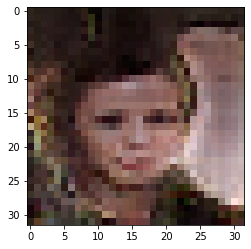

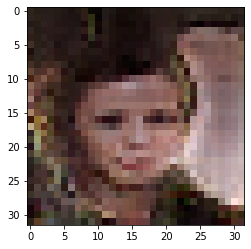

epoch no. 28
epoch no. 28
batch no. 0
batch no. 0


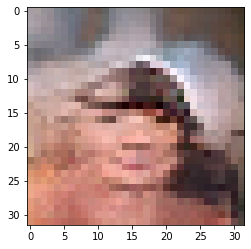

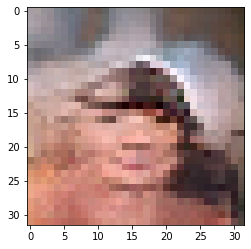

batch no. 200
batch no. 200


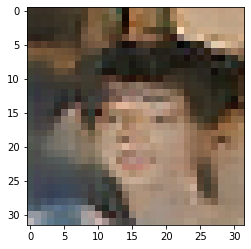

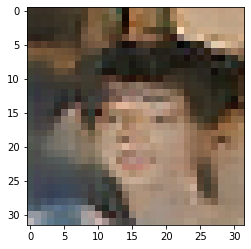

batch no. 400
batch no. 400


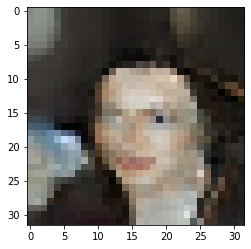

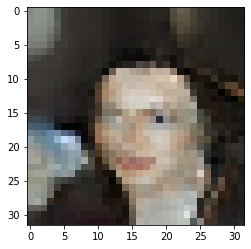

batch no. 600
batch no. 600


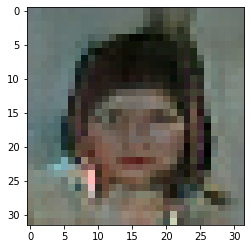

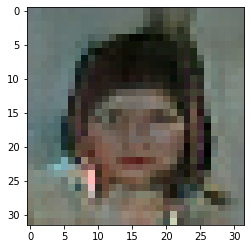

batch no. 800
batch no. 800


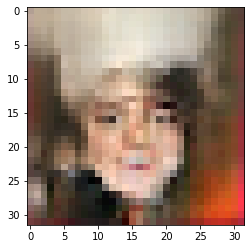

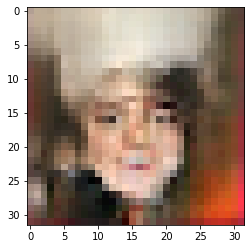

batch no. 1000
batch no. 1000


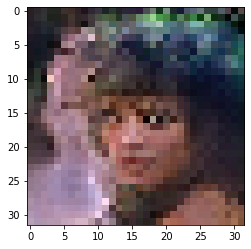

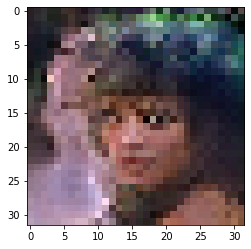

batch no. 1200
batch no. 1200


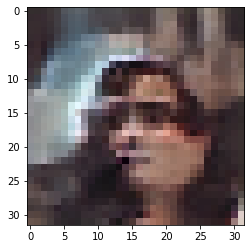

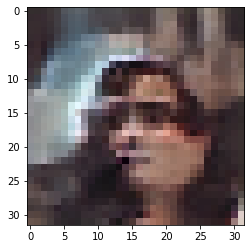

batch no. 1400
batch no. 1400


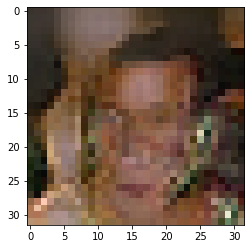

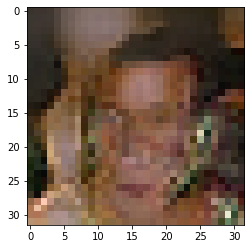

epoch no. 29
epoch no. 29
batch no. 0
batch no. 0


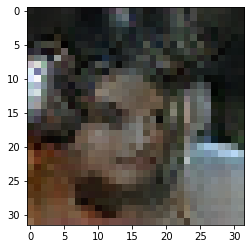

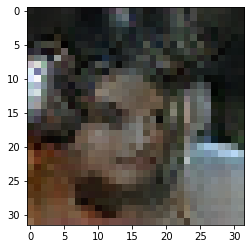

batch no. 200
batch no. 200


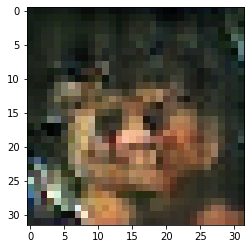

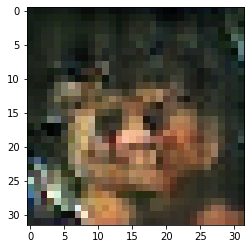

batch no. 400
batch no. 400


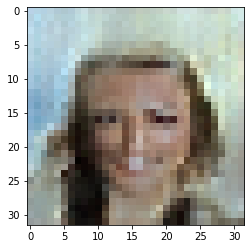

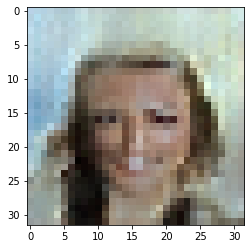

batch no. 600
batch no. 600


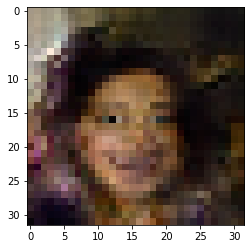

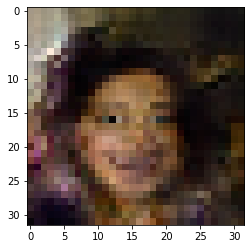

batch no. 800
batch no. 800


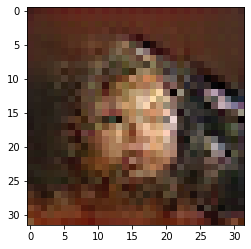

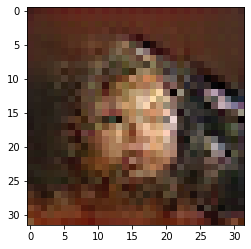

batch no. 1000
batch no. 1000


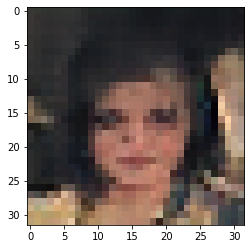

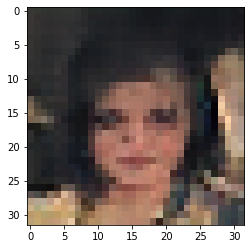

batch no. 1200
batch no. 1200


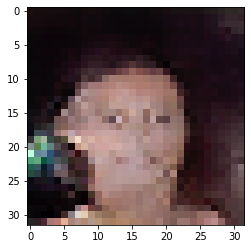

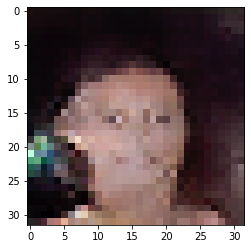

batch no. 1400
batch no. 1400


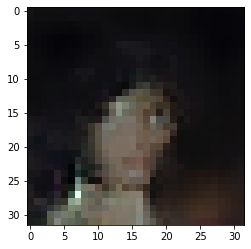

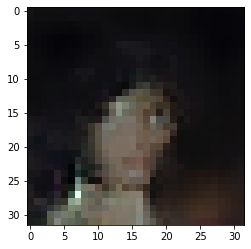

epoch no. 30
epoch no. 30
batch no. 0
batch no. 0


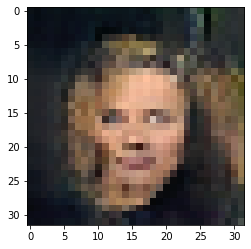

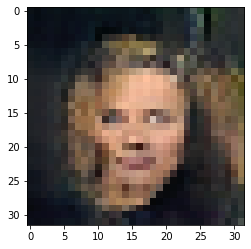

batch no. 200
batch no. 200


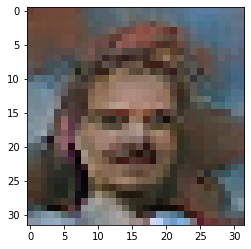

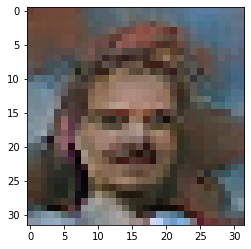

batch no. 400
batch no. 400


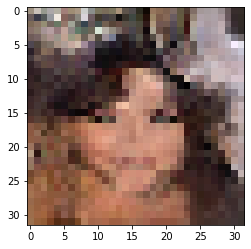

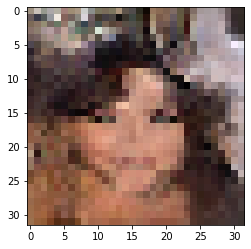

batch no. 600
batch no. 600


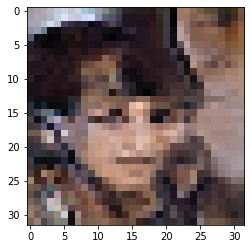

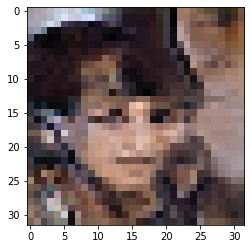

batch no. 800
batch no. 800


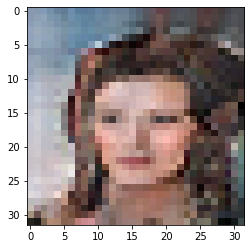

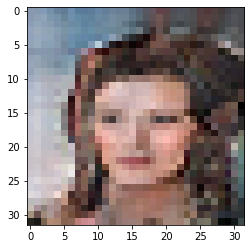

batch no. 1000
batch no. 1000


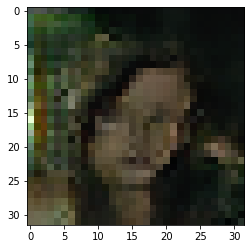

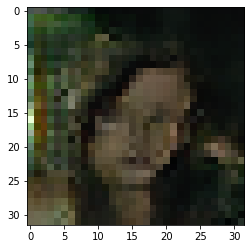

batch no. 1200
batch no. 1200


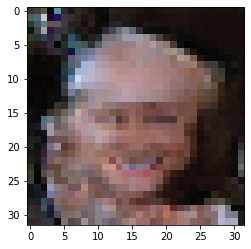

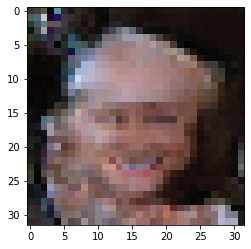

batch no. 1400
batch no. 1400


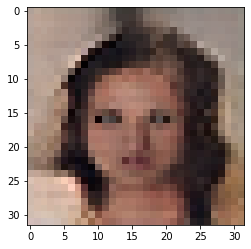

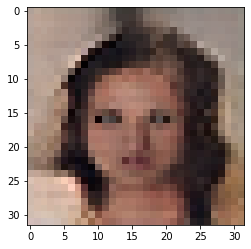

epoch no. 31
epoch no. 31
batch no. 0
batch no. 0


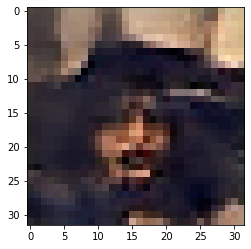

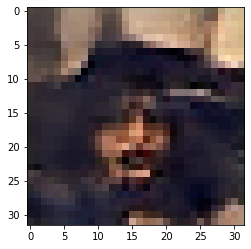

batch no. 200
batch no. 200


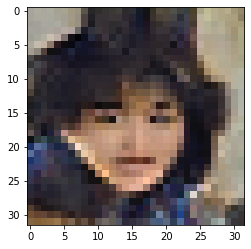

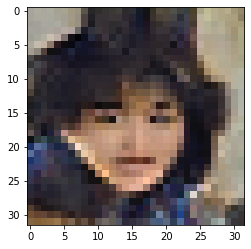

batch no. 400
batch no. 400


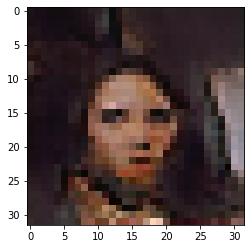

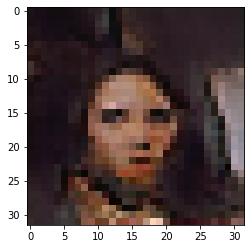

batch no. 600
batch no. 600


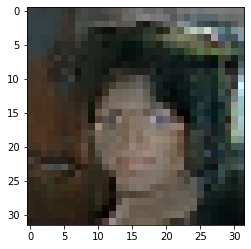

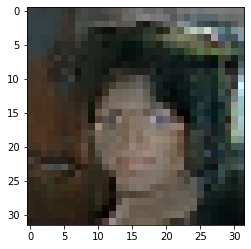

batch no. 800
batch no. 800


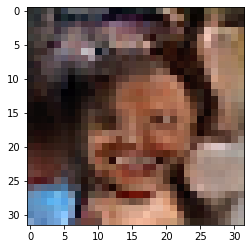

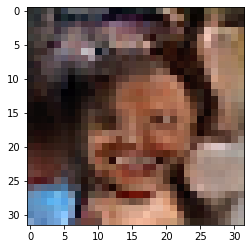

batch no. 1000
batch no. 1000


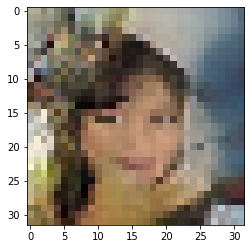

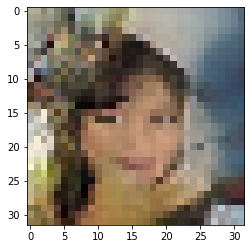

batch no. 1200
batch no. 1200


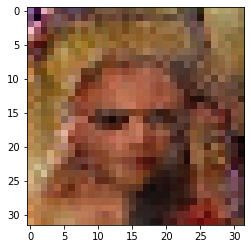

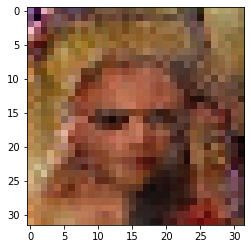

batch no. 1400
batch no. 1400


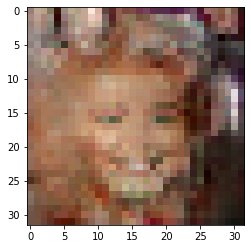

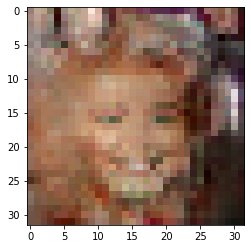

epoch no. 32
epoch no. 32
batch no. 0
batch no. 0


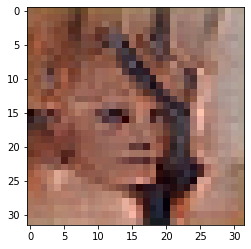

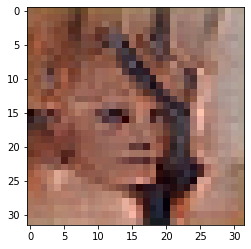

batch no. 200
batch no. 200


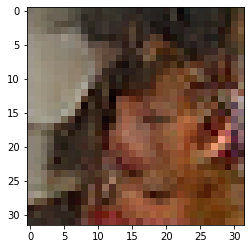

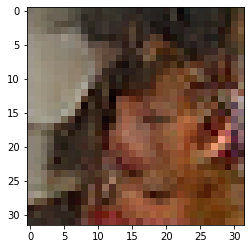

batch no. 400
batch no. 400


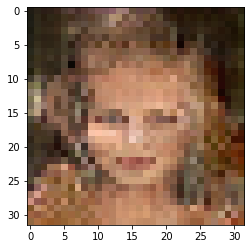

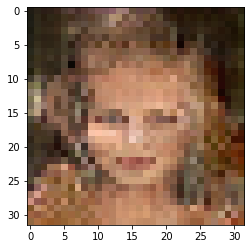

batch no. 600
batch no. 600


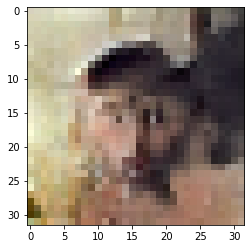

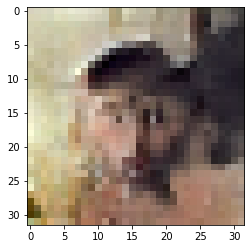

batch no. 800
batch no. 800


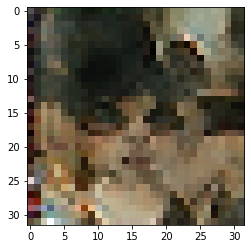

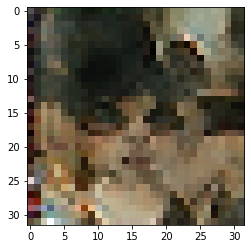

batch no. 1000
batch no. 1000


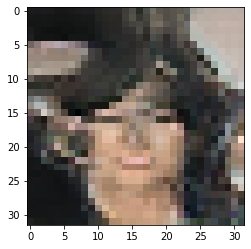

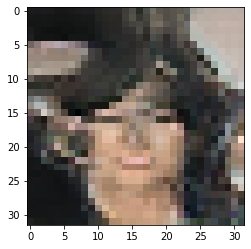

batch no. 1200
batch no. 1200


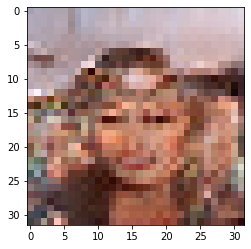

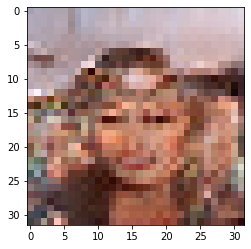

batch no. 1400
batch no. 1400


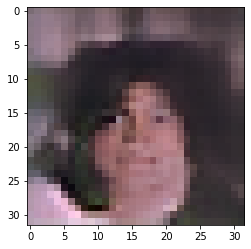

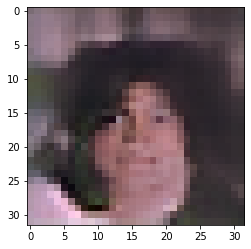

epoch no. 33
epoch no. 33
batch no. 0
batch no. 0


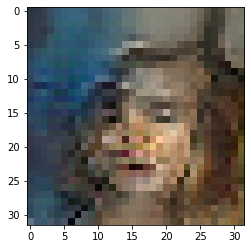

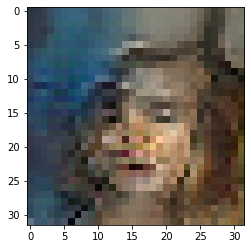

batch no. 200
batch no. 200


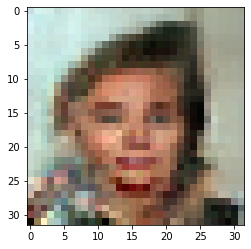

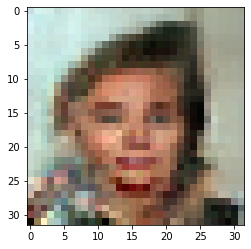

batch no. 400
batch no. 400


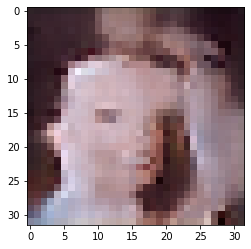

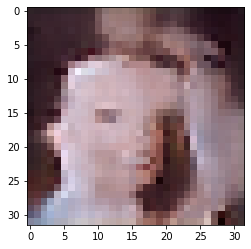

batch no. 600
batch no. 600


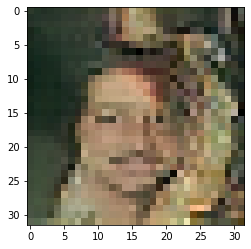

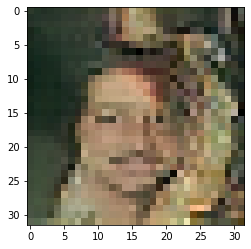

batch no. 800
batch no. 800


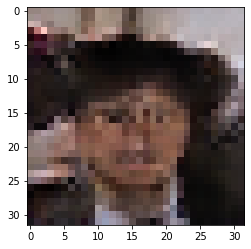

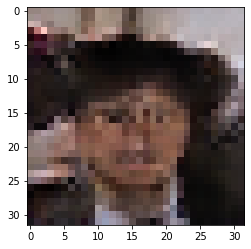

batch no. 1000
batch no. 1000


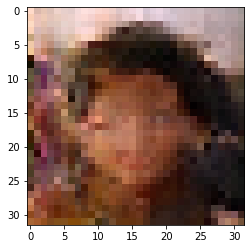

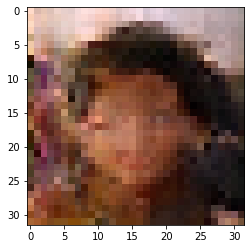

batch no. 1200
batch no. 1200


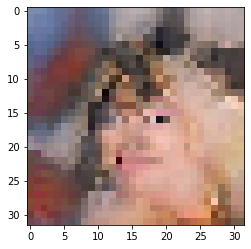

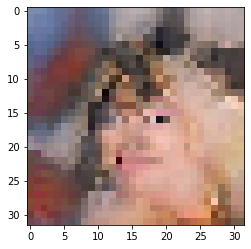

batch no. 1400
batch no. 1400


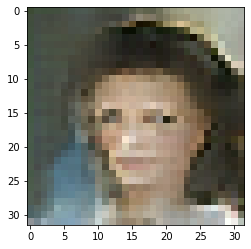

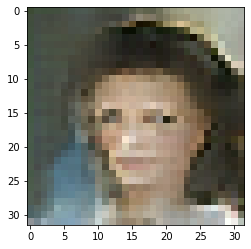

epoch no. 34
epoch no. 34
batch no. 0
batch no. 0


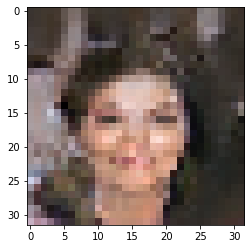

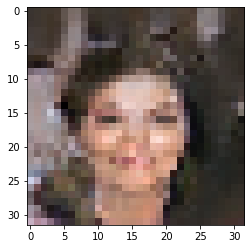

batch no. 200
batch no. 200


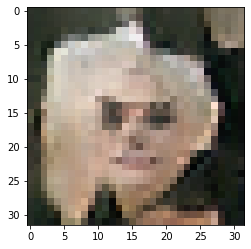

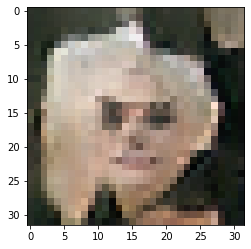

batch no. 400
batch no. 400


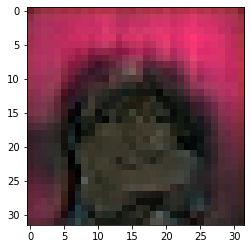

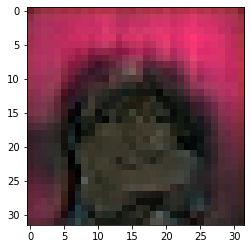

batch no. 600
batch no. 600


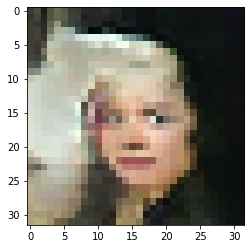

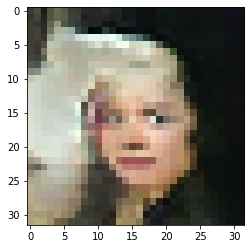

batch no. 800
batch no. 800


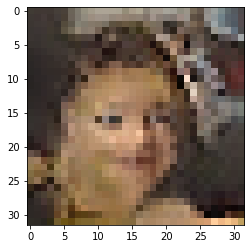

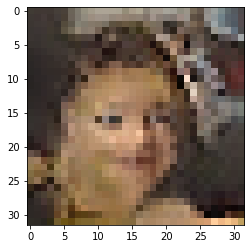

batch no. 1000
batch no. 1000


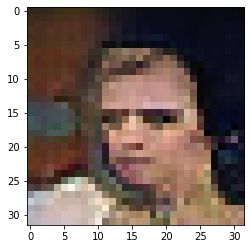

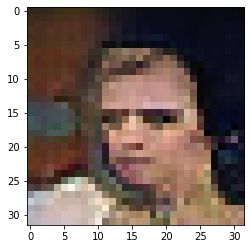

batch no. 1200
batch no. 1200


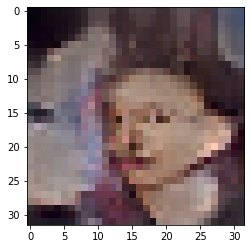

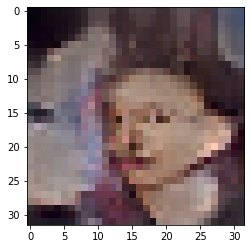

batch no. 1400
batch no. 1400


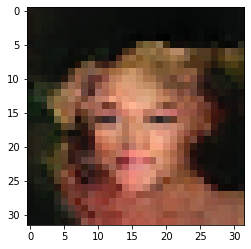

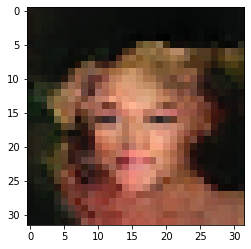

epoch no. 35
epoch no. 35
batch no. 0
batch no. 0


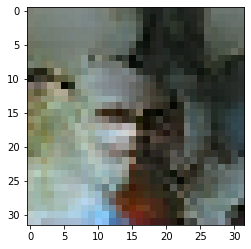

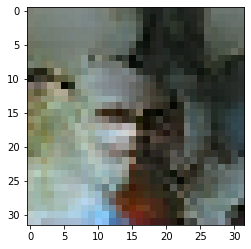

batch no. 200
batch no. 200


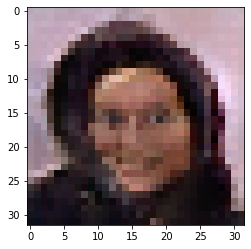

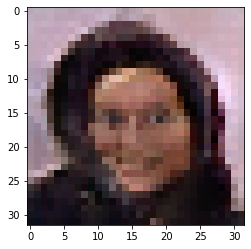

batch no. 400
batch no. 400


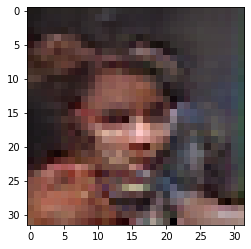

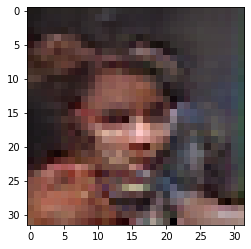

batch no. 600
batch no. 600


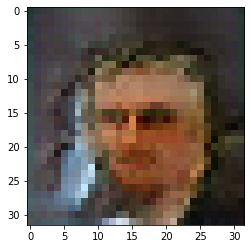

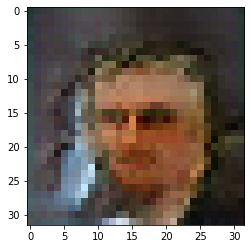

batch no. 800
batch no. 800


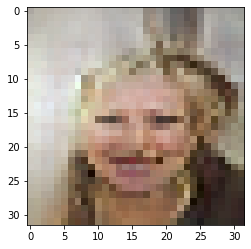

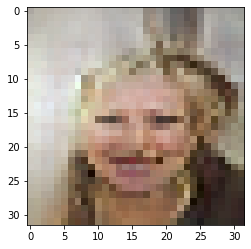

batch no. 1000
batch no. 1000


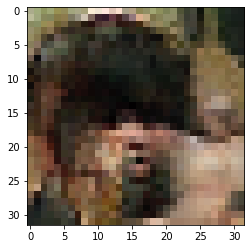

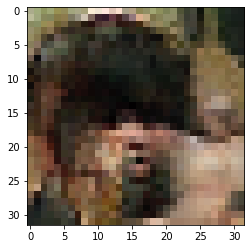

batch no. 1200
batch no. 1200


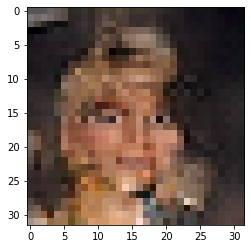

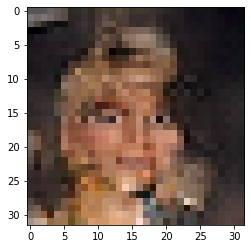

batch no. 1400
batch no. 1400


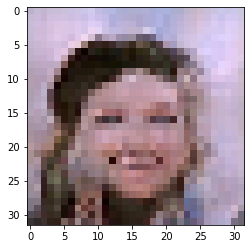

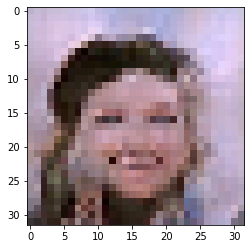

epoch no. 36
epoch no. 36
batch no. 0
batch no. 0


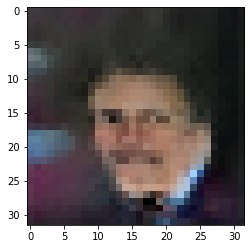

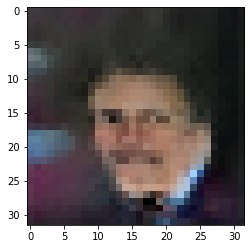

batch no. 200
batch no. 200


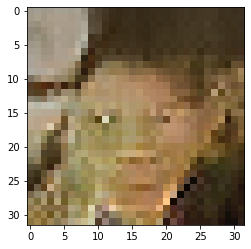

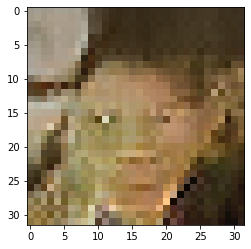

batch no. 400
batch no. 400


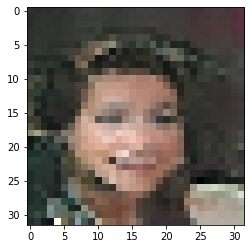

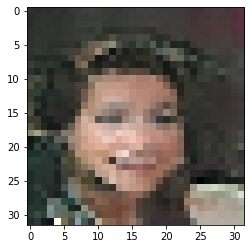

batch no. 600
batch no. 600


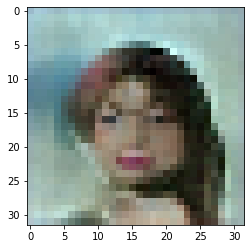

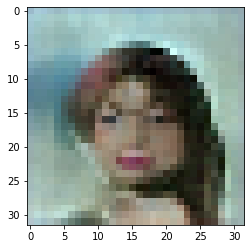

batch no. 800
batch no. 800


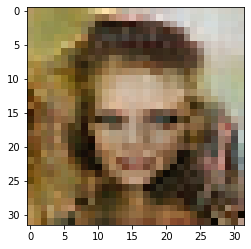

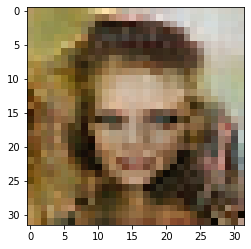

batch no. 1000
batch no. 1000


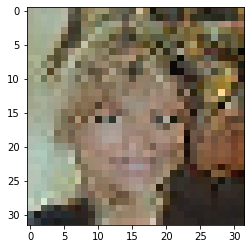

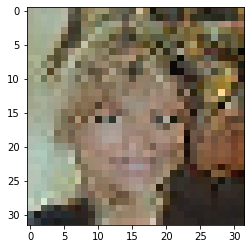

batch no. 1200
batch no. 1200


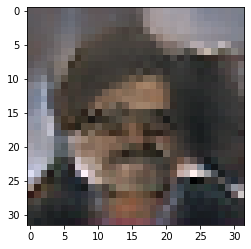

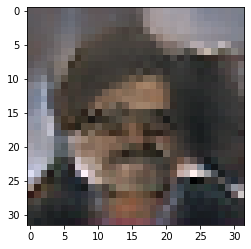

batch no. 1400
batch no. 1400


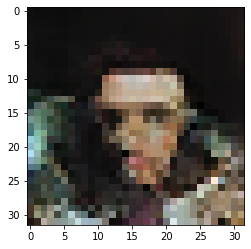

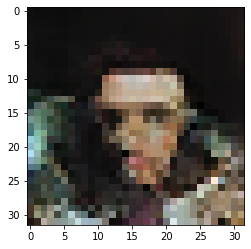

epoch no. 37
epoch no. 37
batch no. 0
batch no. 0


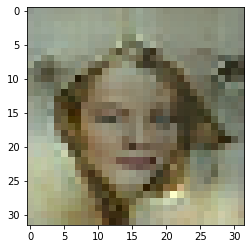

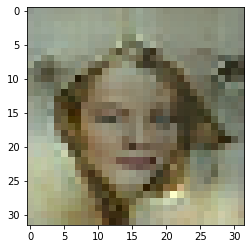

batch no. 200
batch no. 200


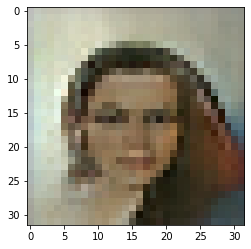

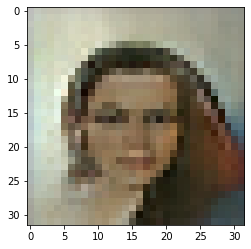

batch no. 400
batch no. 400


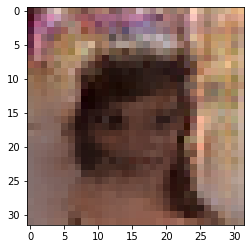

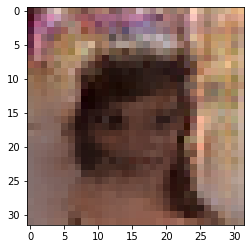

batch no. 600
batch no. 600


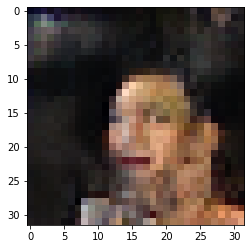

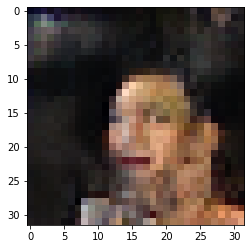

batch no. 800
batch no. 800


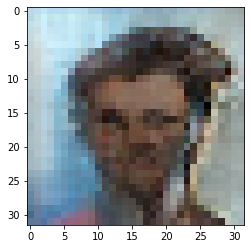

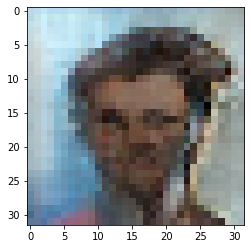

batch no. 1000
batch no. 1000


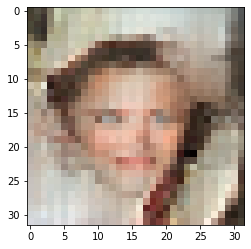

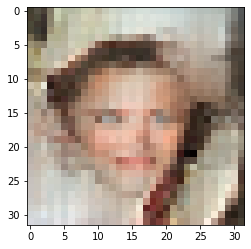

batch no. 1200
batch no. 1200


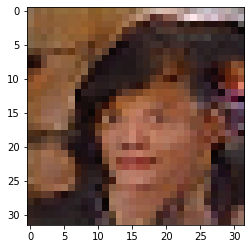

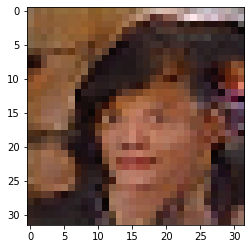

batch no. 1400
batch no. 1400


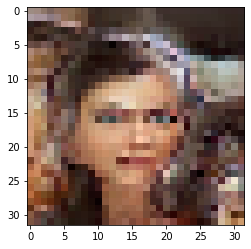

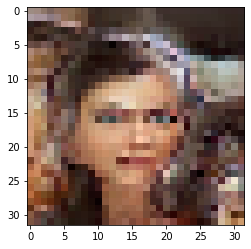

epoch no. 38
epoch no. 38
batch no. 0
batch no. 0


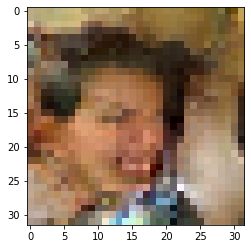

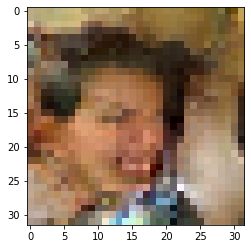

batch no. 200
batch no. 200


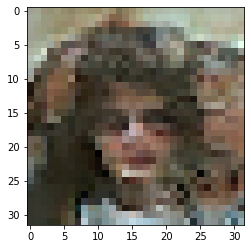

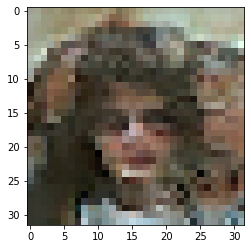

batch no. 400
batch no. 400


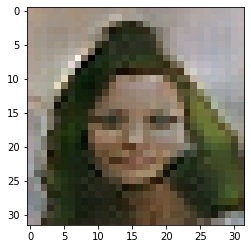

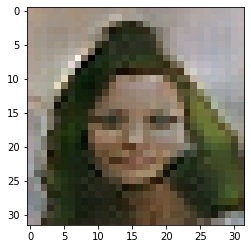

batch no. 600
batch no. 600


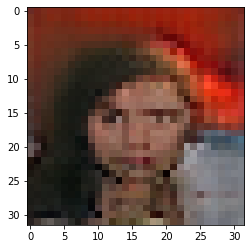

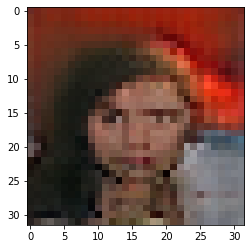

batch no. 800
batch no. 800


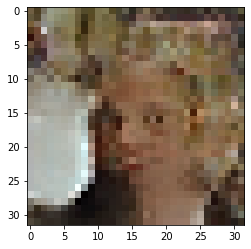

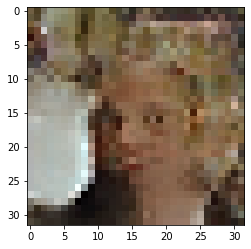

batch no. 1000
batch no. 1000


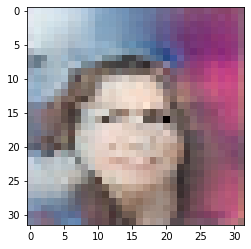

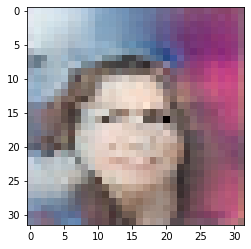

batch no. 1200
batch no. 1200


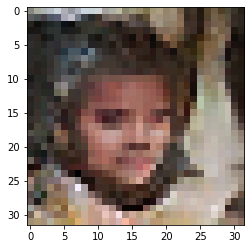

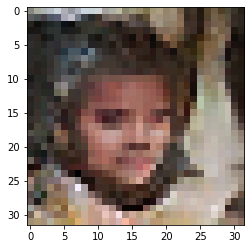

batch no. 1400
batch no. 1400


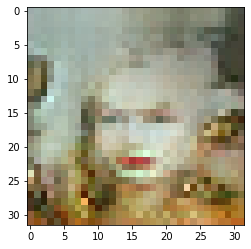

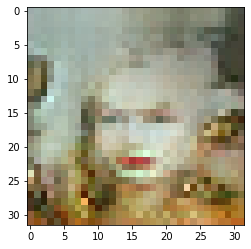

epoch no. 39
epoch no. 39
batch no. 0
batch no. 0


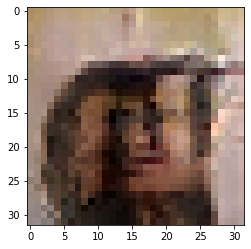

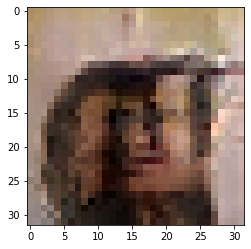

batch no. 200
batch no. 200


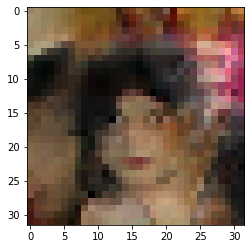

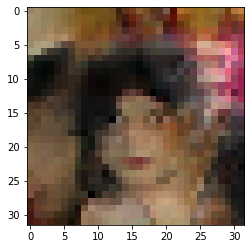

batch no. 400
batch no. 400


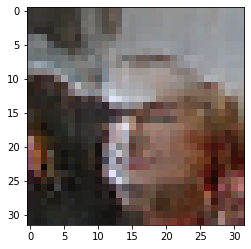

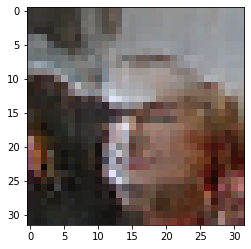

batch no. 600
batch no. 600


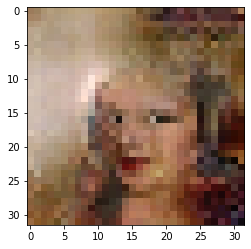

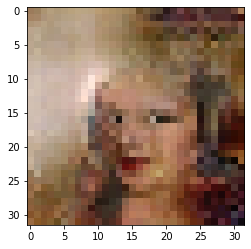

batch no. 800
batch no. 800


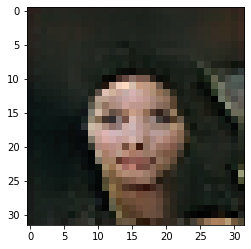

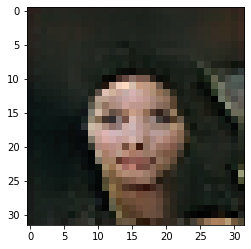

batch no. 1000
batch no. 1000


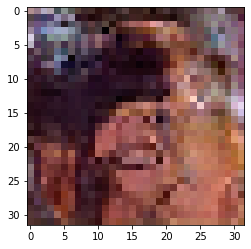

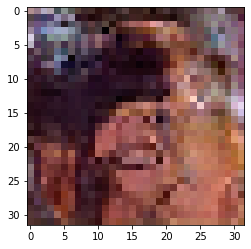

batch no. 1200
batch no. 1200


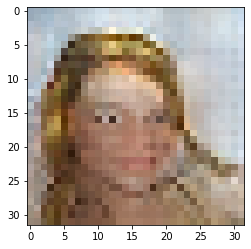

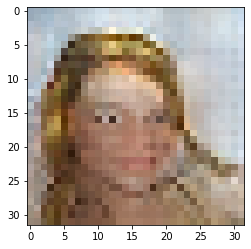

batch no. 1400
batch no. 1400


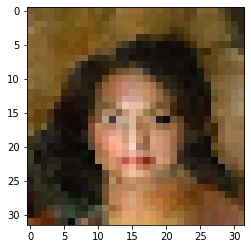

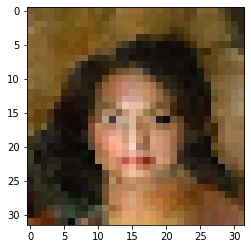

epoch no. 40
epoch no. 40
batch no. 0
batch no. 0


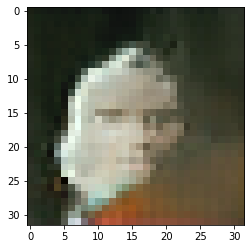

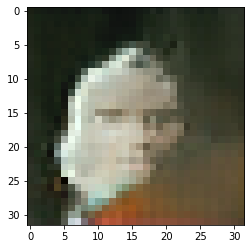

batch no. 200
batch no. 200


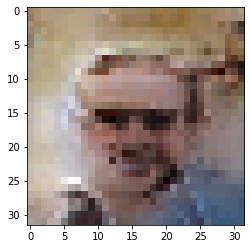

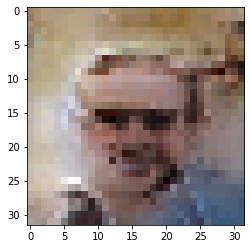

batch no. 400
batch no. 400


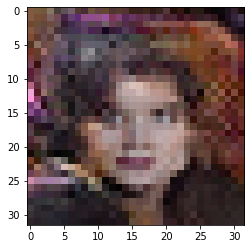

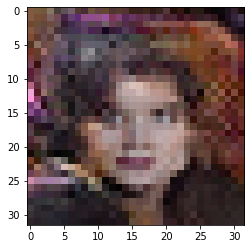

batch no. 600
batch no. 600


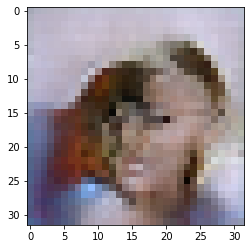

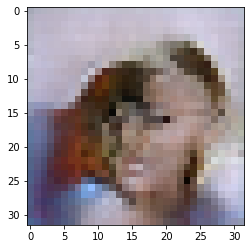

batch no. 800
batch no. 800


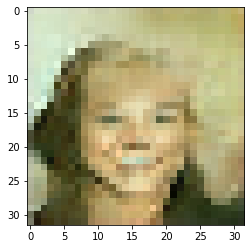

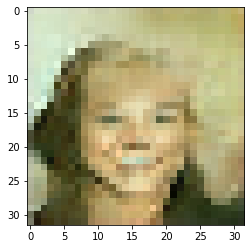

batch no. 1000
batch no. 1000


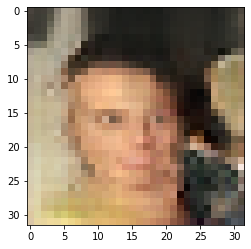

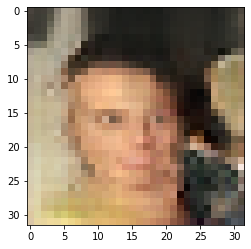

batch no. 1200
batch no. 1200


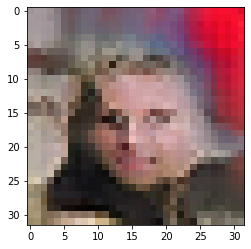

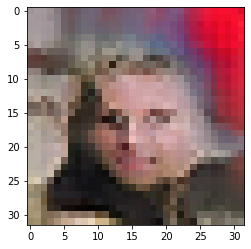

batch no. 1400
batch no. 1400


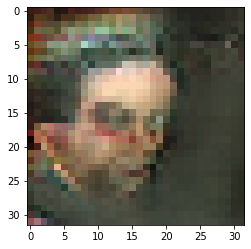

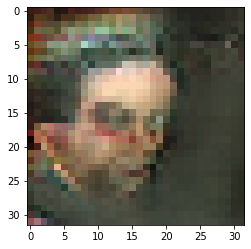

epoch no. 41
epoch no. 41
batch no. 0
batch no. 0


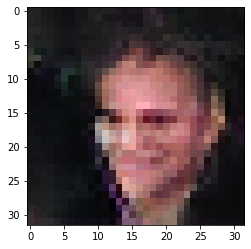

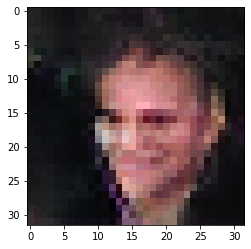

batch no. 200
batch no. 200


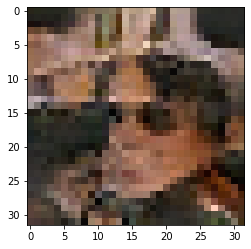

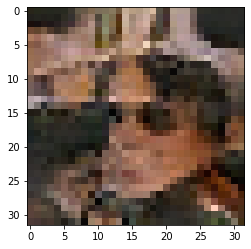

batch no. 400
batch no. 400


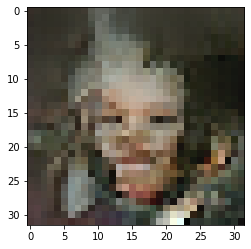

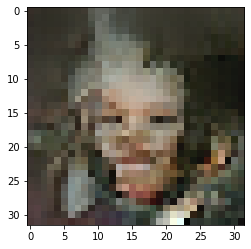

batch no. 600
batch no. 600


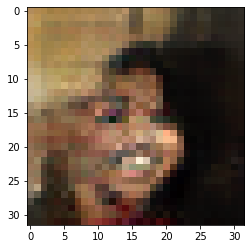

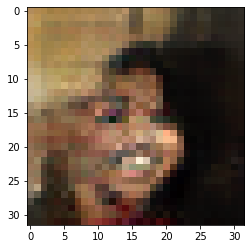

batch no. 800
batch no. 800


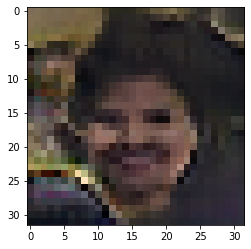

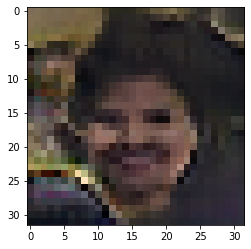

batch no. 1000
batch no. 1000


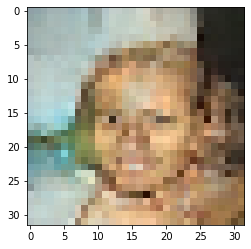

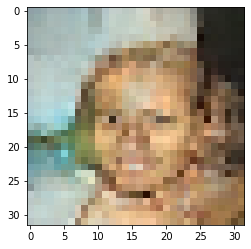

batch no. 1200
batch no. 1200


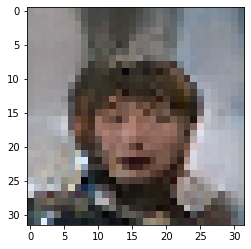

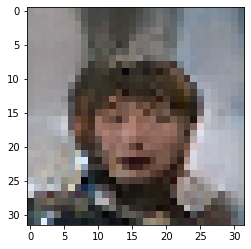

batch no. 1400
batch no. 1400


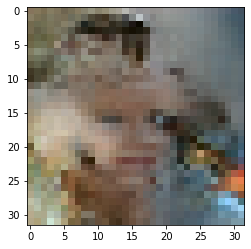

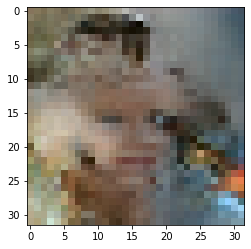

epoch no. 42
epoch no. 42
batch no. 0
batch no. 0


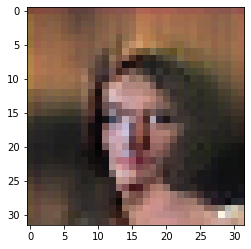

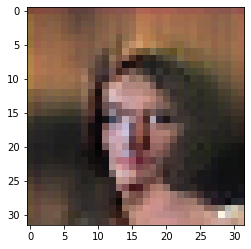

batch no. 200
batch no. 200


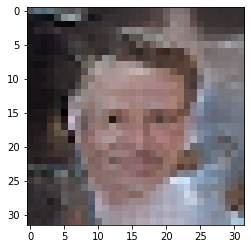

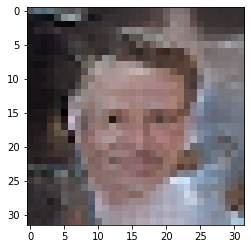

batch no. 400
batch no. 400


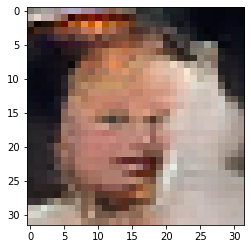

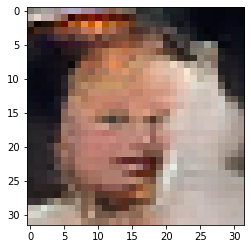

batch no. 600
batch no. 600


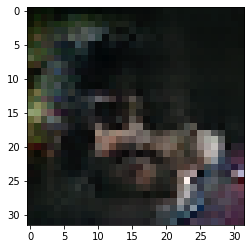

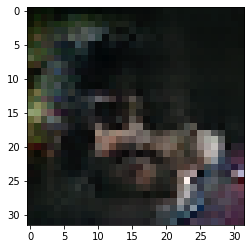

batch no. 800
batch no. 800


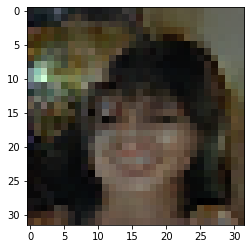

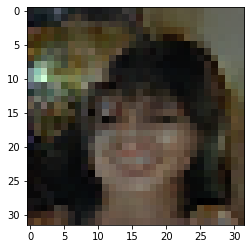

batch no. 1000
batch no. 1000


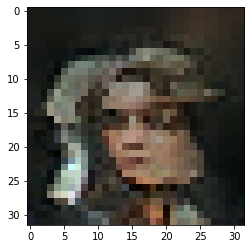

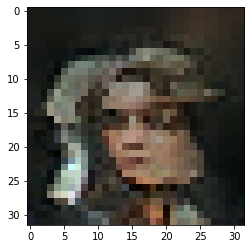

batch no. 1200
batch no. 1200


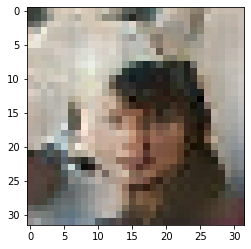

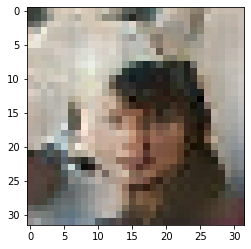

batch no. 1400
batch no. 1400


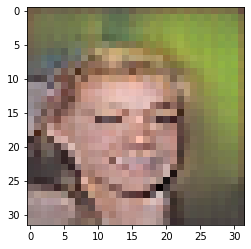

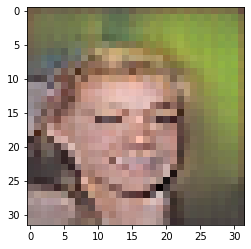

epoch no. 43
epoch no. 43
batch no. 0
batch no. 0


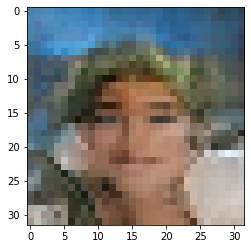

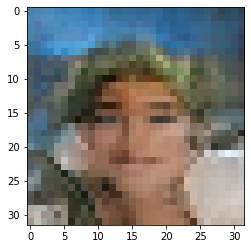

batch no. 200
batch no. 200


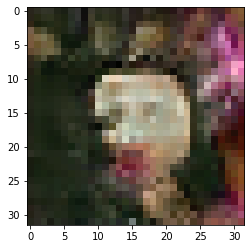

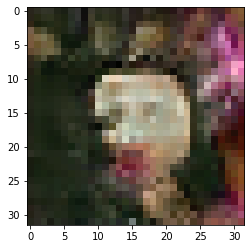

batch no. 400
batch no. 400


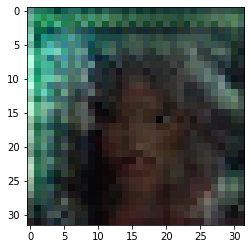

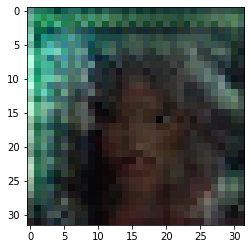

batch no. 600
batch no. 600


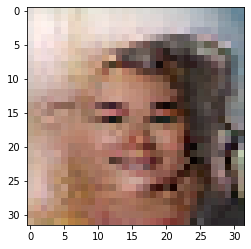

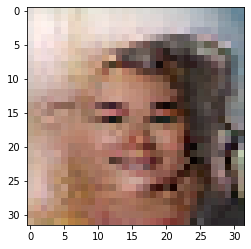

batch no. 800
batch no. 800


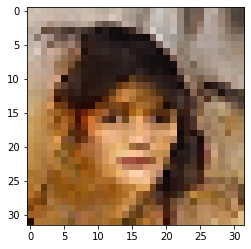

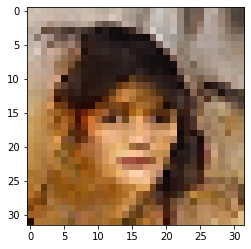

batch no. 1000
batch no. 1000


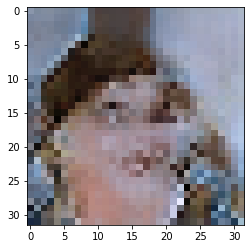

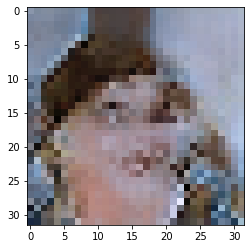

batch no. 1200
batch no. 1200


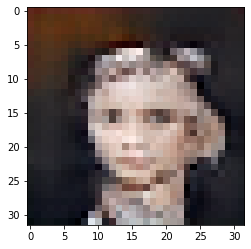

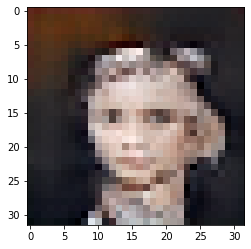

batch no. 1400
batch no. 1400


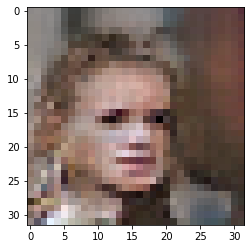

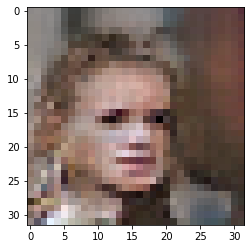

epoch no. 44
epoch no. 44
batch no. 0
batch no. 0


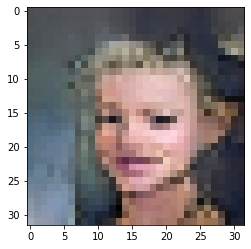

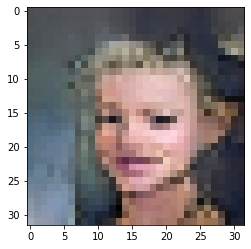

batch no. 200
batch no. 200


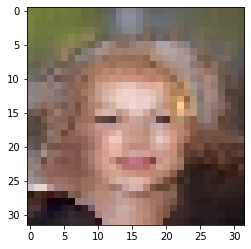

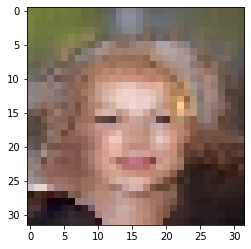

batch no. 400
batch no. 400


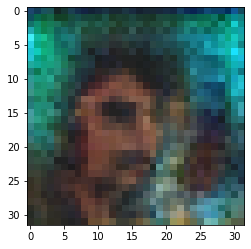

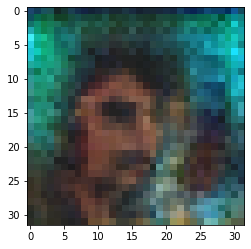

batch no. 600
batch no. 600


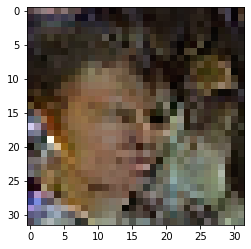

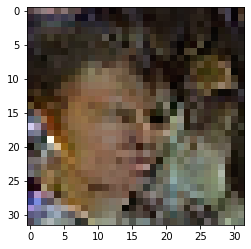

batch no. 800
batch no. 800


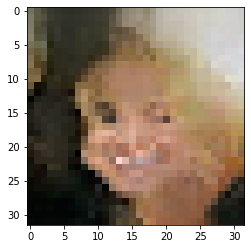

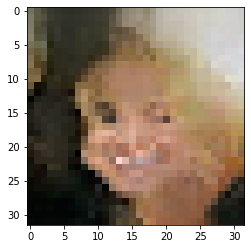

batch no. 1000
batch no. 1000


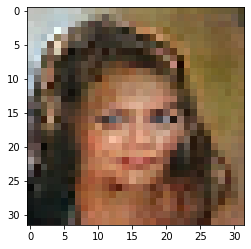

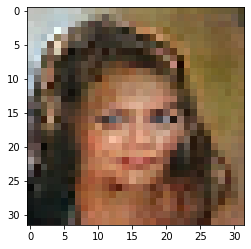

batch no. 1200
batch no. 1200


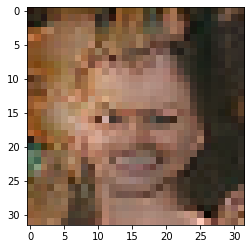

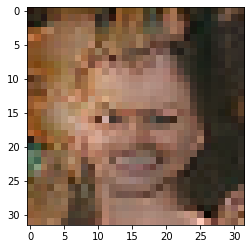

batch no. 1400
batch no. 1400


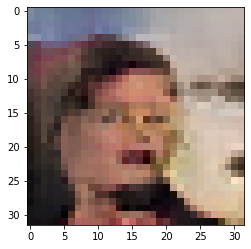

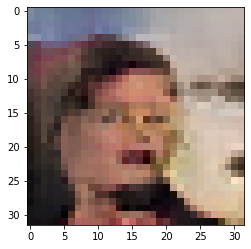

epoch no. 45
epoch no. 45
batch no. 0
batch no. 0


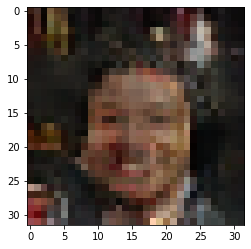

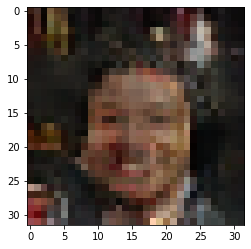

batch no. 200
batch no. 200


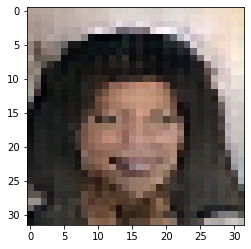

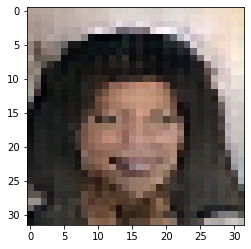

batch no. 400
batch no. 400


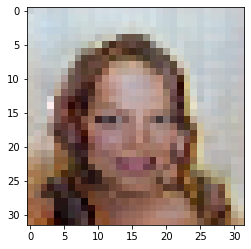

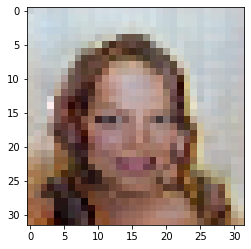

batch no. 600
batch no. 600


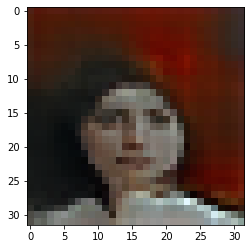

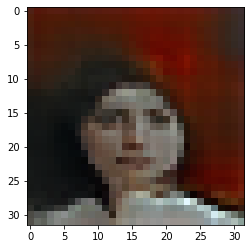

batch no. 800
batch no. 800


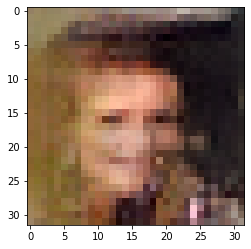

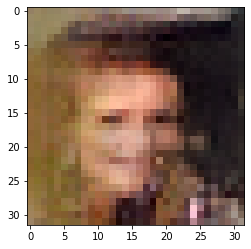

batch no. 1000
batch no. 1000


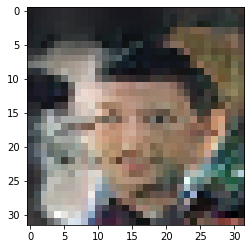

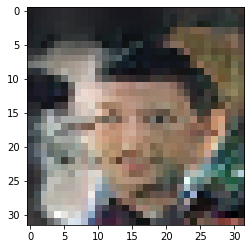

batch no. 1200
batch no. 1200


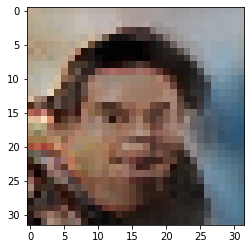

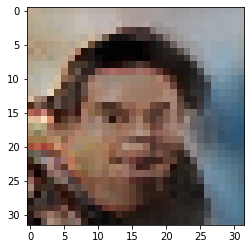

batch no. 1400
batch no. 1400


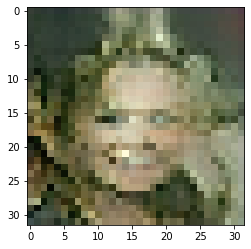

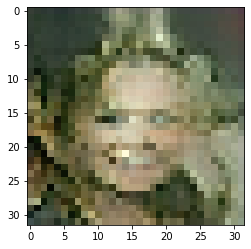

epoch no. 46
epoch no. 46
batch no. 0
batch no. 0


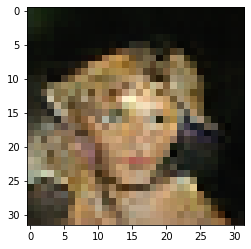

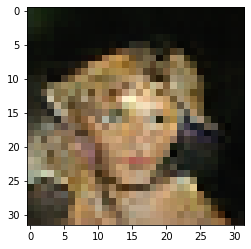

batch no. 200
batch no. 200


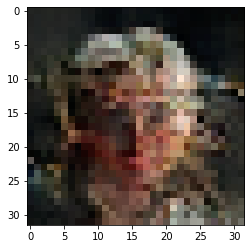

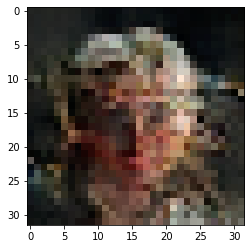

batch no. 400
batch no. 400


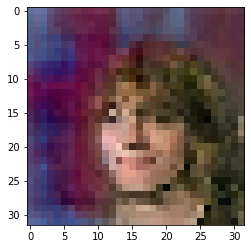

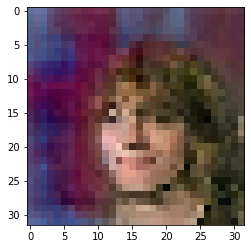

batch no. 600
batch no. 600


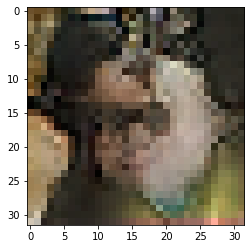

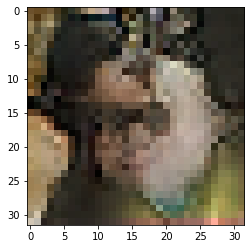

batch no. 800
batch no. 800


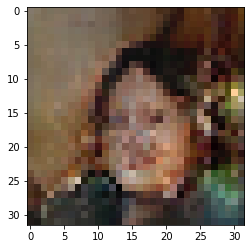

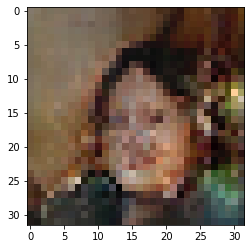

batch no. 1000
batch no. 1000


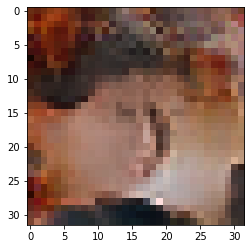

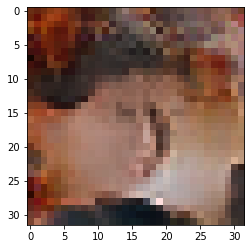

batch no. 1200
batch no. 1200


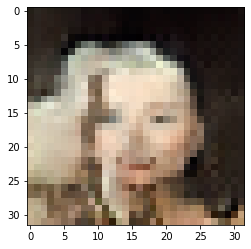

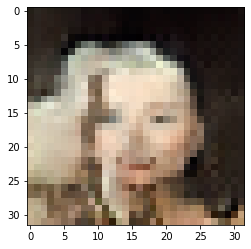

batch no. 1400
batch no. 1400


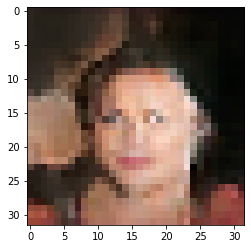

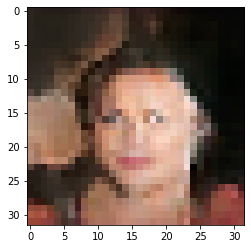

epoch no. 47
epoch no. 47
batch no. 0
batch no. 0


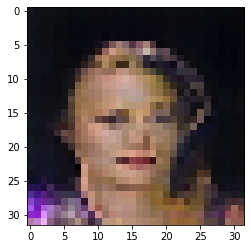

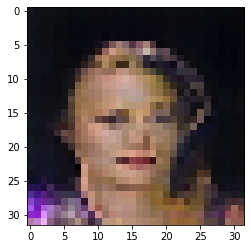

batch no. 200
batch no. 200


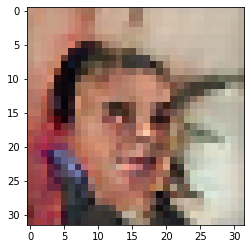

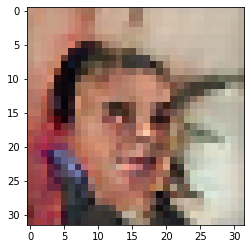

batch no. 400
batch no. 400


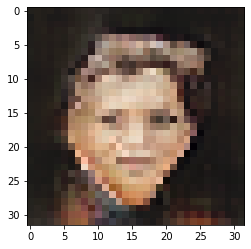

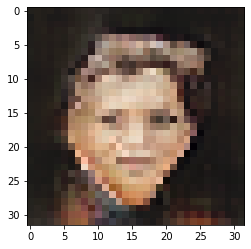

batch no. 600
batch no. 600


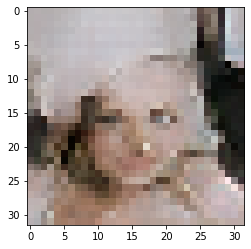

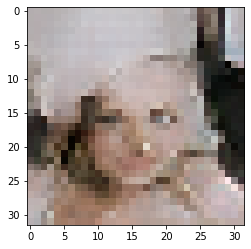

batch no. 800
batch no. 800


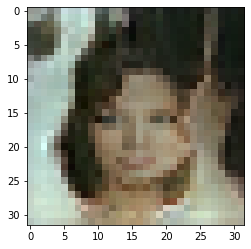

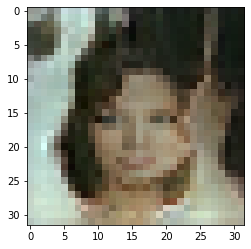

batch no. 1000
batch no. 1000


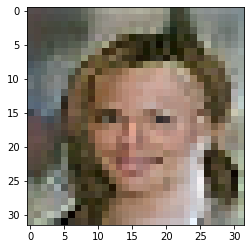

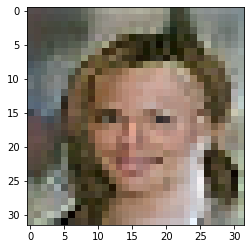

batch no. 1200
batch no. 1200


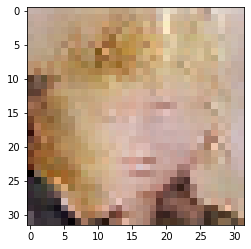

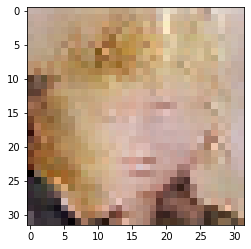

batch no. 1400
batch no. 1400


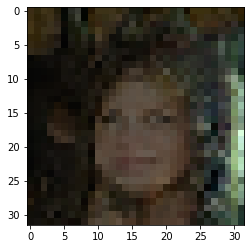

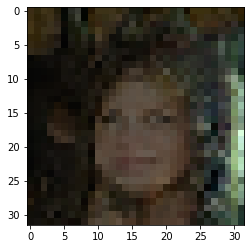

epoch no. 48
epoch no. 48
batch no. 0
batch no. 0


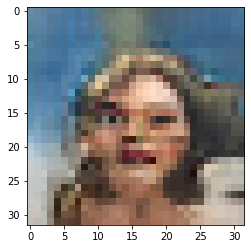

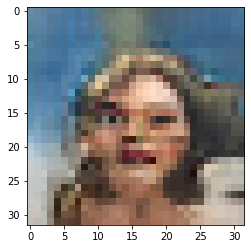

batch no. 200
batch no. 200


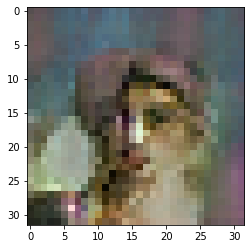

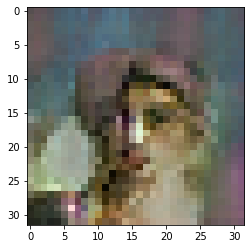

batch no. 400
batch no. 400


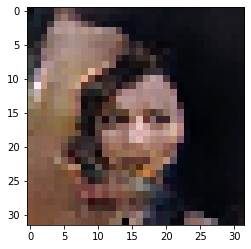

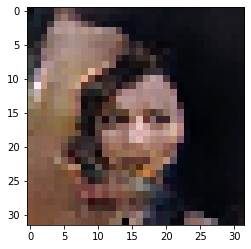

batch no. 600
batch no. 600


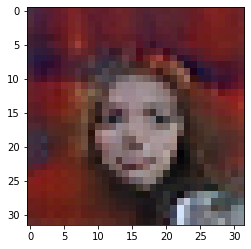

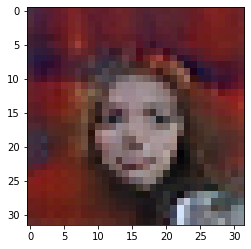

batch no. 800
batch no. 800


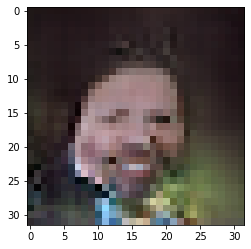

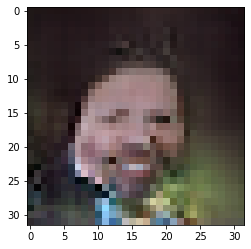

batch no. 1000
batch no. 1000


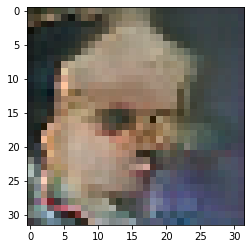

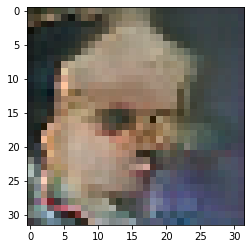

batch no. 1200
batch no. 1200


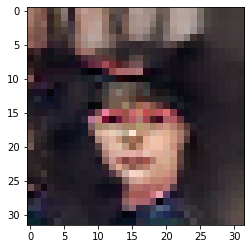

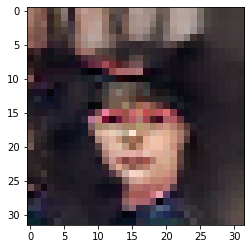

batch no. 1400
batch no. 1400


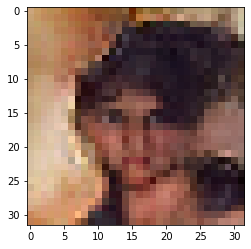

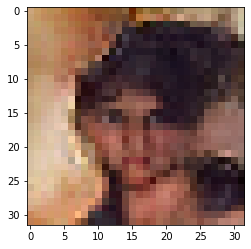

epoch no. 49
epoch no. 49
batch no. 0
batch no. 0


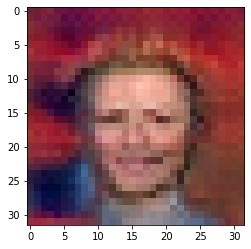

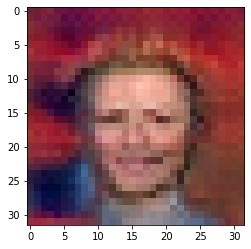

batch no. 200
batch no. 200


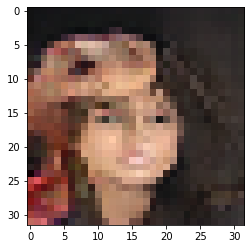

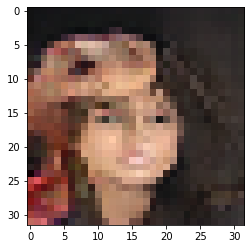

batch no. 400
batch no. 400


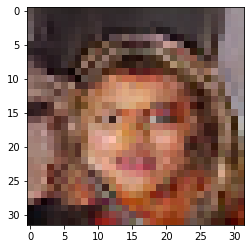

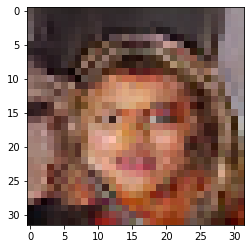

batch no. 600
batch no. 600


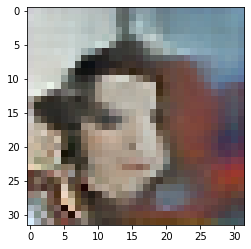

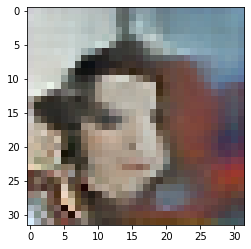

batch no. 800
batch no. 800


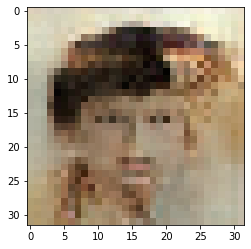

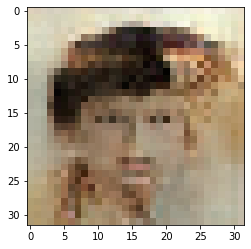

batch no. 1000
batch no. 1000


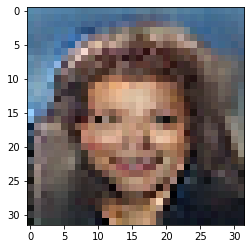

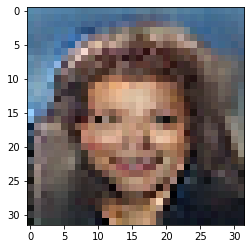

batch no. 1200
batch no. 1200


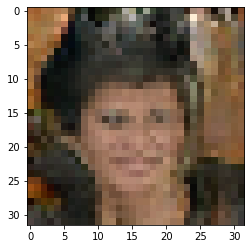

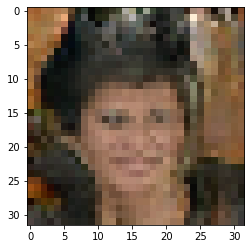

batch no. 1400
batch no. 1400


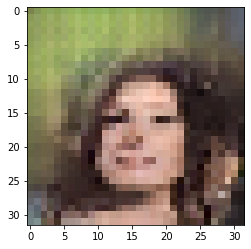

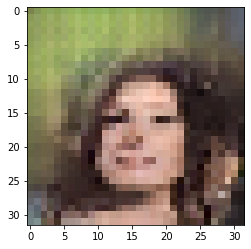

In [18]:
epochs = 50

for epoch in range(epochs):
  print(f'epoch no. {epoch}')
  for i, batch in enumerate(dataset):
    train_discriminator(batch, batch.shape[0])
    train_generator(batch.shape[0])
    if i % 200 == 0:
      print(f'batch no. {i}')
      PATH = '/content/generated_images'
      generate_and_save_image(path=f'{PATH}/epoch_{epoch}batch_{i}.jpg')